In [1]:
import uproot
import awkward as ak
import vector
vector.register_awkward()
from matplotlib import pyplot as plt
import mplhep as hep
hep.style.use("CMS")
import math
import itertools
import os
from typing import Dict, List, Tuple
from numpy.typing import ArrayLike
import numpy as np
import correctionlib
import awkward as ak
import fastjet
import coffea
from coffea.nanoevents.methods import vector
from coffea import nanoevents
from coffea import processor
from coffea.nanoevents.methods import candidate
from coffea.analysis_tools import Weights, PackedSelection
from hist import Hist
ak.behavior.update(vector.behavior)

In [2]:
print(coffea.__version__, coffea.__file__)
print(ak.__version__, ak.__file__)
print(uproot.__version__, uproot.__file__)
print(np.__version__, np.__file__)

0.7.22 /Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/coffea/__init__.py
1.10.5 /Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/awkward/__init__.py
4.3.7 /Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/uproot/__init__.py
1.23.5 /Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/numpy/__init__.py


In [3]:
%load_ext autoreload
%autoreload 2

In [232]:
# # #first way to load root file is using nanoevents, but suffer from low process speed
events = nanoevents.NanoEventsFactory.from_root(
    "../rootfiles/HWW/file1.root",
    schemaclass=nanoevents.NanoAODSchema,
).events()

/Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15SubJet_nBHadrons in <TTree 'Events' (2140 branches) at 0x0001be957250>, taking first instance
  warnings.warn(
/Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15SubJet_nCHadrons in <TTree 'Events' (2140 branches) at 0x0001be957250>, taking first instance
  warnings.warn(
/Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15_nBHadrons in <TTree 'Events' (2140 branches) at 0x0001be957250>, taking first instance
  warnings.warn(
/Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15_nCHadrons in <TTree 'Events' (2140 branc

In [5]:
desired_fields = ["Electron","Muon","FatJet","genWeight","GenPart","FatJetPFCands","PFCands"]
filtered_events = events[desired_fields]
del events

In [6]:
def build_p4(cand):
    return ak.zip(
        {
            "pt": cand.pt,
            "eta": cand.eta,
            "phi": cand.phi,
            "mass": cand.mass,
            "charge": cand.charge,
        },
        with_name="PtEtaPhiMCandidate",
        behavior=candidate.behavior,
    )

#pad array with given value
def pad_val(
    arr: ak.Array,
    target: int,
    value: float, #value can also be Bool variable 
    axis: int = 0,
    to_numpy: bool = True,
    clip: bool = True,
):
    """
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    padded_arr = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=axis)
    # pad_none will fill the array to target length with "None" for dedicated axis
    # "clip" means cut the array to the target length or not
    # fill_none will replace "None" value to some value
    return padded_arr.to_numpy() if to_numpy else padded_arr

def add_selection(
    name: str,
    sel: np.ndarray,
    selection: PackedSelection,
    cutflow: dict = None,
    isData: bool = False,
    signGenWeights: ak.Array = None,
):
    """adds selection to PackedSelection object and the cutflow dictionary"""
    selection.add(name, sel)
    if cutflow is not None: #only add to cutflow dictionary if cutflow is not None
        cutflow[name] = (
            np.sum(selection.all(*selection.names))
            if isData
            # add up sign of genWeights for MC
            else np.sum(signGenWeights[selection.all(*selection.names)])
        )

In [7]:
from typing import Dict, Tuple, Union
from coffea.nanoevents.methods.nanoaod import FatJetArray, GenParticleArray

d_PDGID = 1
c_PDGID = 4
b_PDGID = 5
g_PDGID = 21
TOP_PDGID = 6

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

GAMMA_PDGID = 22
Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25

PI_PDGID = 211
PO_PDGID = 221
PP_PDGID = 111

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

FILL_NONE_VALUE = -99999

JET_DR = 0.8

def to_label(array: ak.Array) -> ak.Array:
    return ak.values_astype(array, np.int32)

def get_pid_mask(
    genparts: GenParticleArray,
    pdgids: Union[int, list],
    ax: int = 2,
    byall: bool = True,
) -> ak.Array:
    """
    Get selection mask for gen particles matching any of the pdgIds in ``pdgids``.
    If ``byall``, checks all particles along axis ``ax`` match.
    """
    gen_pdgids = abs(genparts.pdgId)

    if type(pdgids) is list:
        mask = gen_pdgids == pdgids[0]
        for pdgid in pdgids[1:]:
            mask = mask | (gen_pdgids == pdgid)
    else:
        mask = gen_pdgids == pdgids

    return ak.all(mask, axis=ax) if byall else mask

def match_H(genparts: GenParticleArray, fatjet: FatJetArray):
    """Gen matching for Higgs samples.

    An edited version of the function that returns the genquark info that is useful for LP method.
    """

    higgs = ak.firsts(genparts[get_pid_mask(genparts, HIGGS_PDGID, byall=False) * genparts.hasFlags(GEN_FLAGS)])
    matched_higgs_mask = fatjet.delta_r(higgs) < 0.8

    children_mask = get_pid_mask(higgs.children, [W_PDGID], byall=False)
    is_hww = ak.any(children_mask, axis=1)

    # order by mass, select lower mass child as V* and higher as V
    higgs_children = higgs.children[children_mask]
    children_mass = higgs_children.mass
    v_star = ak.firsts(higgs_children[ak.argmin(children_mass, axis=1, keepdims=True)])
    v = ak.firsts(higgs_children[ak.argmax(children_mass, axis=1, keepdims=True)])

    # VV daughters
    # requires coffea-0.7.21
    all_daus = higgs_children.distinctChildrenDeep
    all_daus_flat = ak.flatten(all_daus, axis=2)  # flattents the daughters of the two Ws
    all_daus_flat_pdgId = abs(all_daus_flat.pdgId)

    # the following tells you about the decay
    num_quarks = ak.sum(all_daus_flat_pdgId <= b_PDGID, axis=1)
    num_leptons = ak.sum(
        (all_daus_flat_pdgId == ELE_PDGID) | (all_daus_flat_pdgId == MU_PDGID) | (all_daus_flat_pdgId == TAU_PDGID),
        axis=1,
    )
    num_electrons = ak.sum(all_daus_flat_pdgId == ELE_PDGID, axis=1)
    num_muons = ak.sum(all_daus_flat_pdgId == MU_PDGID, axis=1)
    num_taus = ak.sum(all_daus_flat_pdgId == TAU_PDGID, axis=1)

    # the following tells you about the matching
    # prongs except neutrino
    neutrinos = (
        (all_daus_flat_pdgId == vELE_PDGID) | (all_daus_flat_pdgId == vMU_PDGID) | (all_daus_flat_pdgId == vTAU_PDGID)
    )

    leptons = (all_daus_flat_pdgId == ELE_PDGID) | (all_daus_flat_pdgId == MU_PDGID) | (all_daus_flat_pdgId == TAU_PDGID)

    # num_m: number of matched leptons
    # number of quarks excludes neutrino and leptons
    num_m_quarks = ak.sum(fatjet.delta_r(all_daus_flat[~neutrinos & ~leptons]) < JET_DR, axis=1)
    num_m_leptons = ak.sum(fatjet.delta_r(all_daus_flat[leptons]) < JET_DR, axis=1)
    num_m_cquarks = ak.sum(fatjet.delta_r(all_daus_flat[all_daus_flat.pdgId == b_PDGID]) < JET_DR, axis=1)

    lep_daughters = all_daus_flat[leptons]
    # parent = ak.firsts(lep_daughters[fatjet.delta_r(lep_daughters) < JET_DR].distinctParent)
    parent = ak.firsts(lep_daughters.distinctParent)
    
    iswlepton = parent.mass == v.mass
    iswstarlepton = parent.mass == v_star.mass
    
    genVars = {"fj_genH_pt": ak.fill_none(higgs.pt, FILL_NONE_VALUE)}

    genVVars = {
        "fj_genH_jet": fatjet.delta_r(higgs),
        "fj_genV_dR": fatjet.delta_r(v),
        "fj_genVstar": fatjet.delta_r(v_star),
        "genV_genVstar_dR": v.delta_r(v_star),
    }

    genHVVVars = {
        "fj_isHVV": is_hww,
        "fj_isHVV_Matched": matched_higgs_mask,
        "fj_isHVV_4q": to_label((num_quarks == 4) & (num_leptons == 0)),
        "fj_isHVV_elenuqq": to_label((num_electrons == 1) & (num_quarks == 2) & (num_leptons == 1)),
        "fj_isHVV_munuqq": to_label((num_muons == 1) & (num_quarks == 2) & (num_leptons == 1)),
        "fj_isHVV_taunuqq": to_label((num_taus == 1) & (num_quarks == 2) & (num_leptons == 1)),
        "fj_isHVV_Vlepton": iswlepton,
        "fj_isHVV_Vstarlepton": iswstarlepton,
        "fj_genRes_mass": higgs.mass,
        "fj_nquarks": num_m_quarks,
        "fj_ncquarks": num_m_cquarks,
        "fj_lepinprongs": num_m_leptons,
        "lep_daughters": leptons,
        "all_daus": all_daus,
    }

    lepVars = {
        "lepton_pt": all_daus_flat[leptons].pt,
        "lepton_eta": all_daus_flat[leptons].eta,
        "lepton_phi": all_daus_flat[leptons].phi,
        "lepton_mass": all_daus_flat[leptons].mass,
    }

    quarkVars = {
        "quark_pt": all_daus_flat[all_daus_flat_pdgId <= b_PDGID].pt,
        "quark_eta": all_daus_flat[all_daus_flat_pdgId <= b_PDGID].eta,
        "quark_phi": all_daus_flat[all_daus_flat_pdgId <= b_PDGID].phi,
        "quark_mass": all_daus_flat[all_daus_flat_pdgId <= b_PDGID].mass,
    }

    genVars = {**genVars, **genVVars, **genHVVVars, **lepVars, **quarkVars}

    return genVars

In [328]:
isData = False
signGenWeights = None if isData else np.sign(filtered_events["genWeight"]) #get genWeight sign, because only the sign matters
n_events = len(filtered_events) if isData else int(np.sum(signGenWeights)) #events number for MC events should be the sum of "sign"
selection = PackedSelection() #initialize a new object

# define the cutflow table to debug
cutflow = {}
cutflow["all"] = n_events

########## 1. leading jet pT > 250GeV
fatjets = filtered_events.FatJet
preselection_cut_jet = np.prod(
    pad_val(
        (filtered_events.FatJet.pt > 250),
        1, #pad to num_jets length
        False,  #pad with value False
        axis=1, #pad to axis=1
    ),
    axis=1,
)

add_selection(
    "at least 1 AK8 jet with pT>250GeV", #string name
    preselection_cut_jet.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)

########## 2. one good lepton selection
muons = ak.with_field(filtered_events.Muon, 0, "flavor")
electrons = ak.with_field(filtered_events.Electron, 1, "flavor")

# OBJECT: muons
loose_muons = (
    (((muons.pt > 30) & (muons.pfRelIso04_all < 0.25)) | (muons.pt > 55))
    & (np.abs(muons.eta) < 2.4)
    & (muons.looseId)
)
n_loose_muons = ak.sum(loose_muons, axis=1)

good_muons = (
    (muons.pt > 30)
    & (np.abs(muons.eta) < 2.4)
    & (np.abs(muons.dz) < 0.1)
    & (np.abs(muons.dxy) < 0.05)
    & (muons.sip3d <= 4.0)
    & muons.mediumId
    & (((muons.pfRelIso04_all < 0.15) & (muons.pt < 55)) | (muons.pt >= 55))
)
n_good_muons = ak.sum(good_muons, axis=1)

# OBJECT: electrons
loose_electrons = (
    (((electrons.pt > 38) & (electrons.pfRelIso03_all < 0.25)) | (electrons.pt > 120))
    & (np.abs(electrons.eta) < 2.4)
    & ((np.abs(electrons.eta) < 1.44) | (np.abs(electrons.eta) > 1.57))
    & (electrons.cutBased >= electrons.LOOSE)
)
n_loose_electrons = ak.sum(loose_electrons, axis=1)

good_electrons = (
    (electrons.pt > 38)
    & (np.abs(electrons.eta) < 2.4)
    & ((np.abs(electrons.eta) < 1.44) | (np.abs(electrons.eta) > 1.57))
    & (np.abs(electrons.dz) < 0.1)
    & (np.abs(electrons.dxy) < 0.05)
    & (electrons.sip3d <= 4.0)
    & (electrons.mvaFall17V2noIso_WP90)
    & (((electrons.pfRelIso03_all < 0.15) & (electrons.pt < 120)) | (electrons.pt >= 120))
)
n_good_electrons = ak.sum(good_electrons, axis=1)

sel_mu = (n_good_muons == 1) & (n_good_electrons == 0) & (n_loose_electrons == 0) & (~ak.any(loose_muons & ~good_muons, 1))
sel_ele = (n_good_muons == 0) & (n_good_electrons == 1) & (n_loose_electrons == 0) & (~ak.any(loose_electrons & ~good_electrons, 1))

preselection_cut_lep = pad_val(
        (sel_mu | sel_ele) , #mass and pT cut of each jet in event
        len(filtered_events), #pad to num_jets length
        False,  #pad with value False
        )

add_selection(
    "lepton selection", #string name
    preselection_cut_lep.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)

########## 3. lepton inside the jet
# get candidate lepton
goodleptons = ak.concatenate([muons[good_muons], electrons[good_electrons]], axis=1)  # concat muons and electrons
goodleptons = goodleptons[ak.argsort(goodleptons.pt, ascending=False)]  # sort by pt

candidatelep = ak.firsts(goodleptons)  # pick highest pt
candidatelep_p4 = build_p4(candidatelep)  # build p4 for candidate lepton

# AK8 fatjets
fatjets = filtered_events.FatJet
fatjet_selector = (fatjets.pt > 200) & (abs(fatjets.eta) < 2.5) & fatjets.isTight
good_fatjets = fatjets[fatjet_selector]
good_fatjets = good_fatjets[ak.argsort(good_fatjets.pt, ascending=False)]  # sort them by pt

# choose candidate fatjet
fj_idx_lep = ak.argmin(good_fatjets.delta_r(candidatelep_p4), axis=1, keepdims=True)
candidatefj = ak.firsts(good_fatjets[fj_idx_lep])

lep_fj_dr = candidatefj.delta_r(candidatelep_p4)

preselection_cut_lepINjet = pad_val(
        (lep_fj_dr < 0.8) , #mass and pT cut of each jet in event
        len(filtered_events), #pad to num_jets length
        False,  #pad with value False
        )

add_selection(
    "lepton in jet selection", #string name
    preselection_cut_lepINjet.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)


########## 4. Gen-matching --> HWW jets

genVars = match_H(filtered_events.GenPart, candidatefj)

preselection_cut_hww = pad_val(
        (genVars["fj_isHVV"] == 1) , #mass and pT cut of each jet in event
        len(filtered_events), #pad to num_jets length
        False,  #pad with value False
        )
add_selection(
    "is HWW", #string name
    preselection_cut_hww.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)

########## 5. Gen-matching --> HWW Matched jets
preselection_cut_hww_matched = pad_val(
        (genVars["fj_isHVV_Matched"] == 1) , #mass and pT cut of each jet in event
        len(filtered_events), #pad to num_jets length
        False,  #pad with value False
        )
add_selection(
    "is HWW matched", #string name
    preselection_cut_hww_matched.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)

########## 6. Gen-matching --> HWWlnuqq jets
preselection_cut_hwwlnuqq = pad_val(
        ((genVars["fj_isHVV_elenuqq"] == 1) | (genVars["fj_isHVV_munuqq"] == 1)) , #mass and pT cut of each jet in event
        len(filtered_events), #pad to num_jets length
        False,  #pad with value False
        )
add_selection(
    "is HWWlnuqq", #string name
    preselection_cut_hwwlnuqq.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)

/Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/coffea/nanoevents/methods/nanoaod.py:107: UserWarning: distinctChildrenDeep may not give correct answers for all generators!
  warnings.warn(


In [113]:
def getGenLepGenQuarks(dataset, genparts: GenParticleArray):
    """Gen matching for Higgs samples or Top samples.

    An edited version of the function that returns the genquark info that is useful for LP method.
    """
    if "HToWW" in dataset:
        higgs = ak.firsts(genparts[get_pid_mask(genparts, HIGGS_PDGID, byall=False) * genparts.hasFlags(GEN_FLAGS)])

        children_mask = get_pid_mask(higgs.children, [W_PDGID], byall=False)

        # order by mass, select lower mass child as V* and higher as V
        higgs_children = higgs.children[children_mask]

        # VV daughters
        # requires coffea-0.7.21
        all_daus = higgs_children.distinctChildrenDeep  # TODO: double check it's always 4
        all_daus_flat = ak.flatten(all_daus, axis=2)  # flattents the daughters of the two Ws
        all_daus_flat_pdgId = abs(all_daus_flat.pdgId)

        # the following tells you about the matching
        leptons = (all_daus_flat_pdgId == ELE_PDGID) | (all_daus_flat_pdgId == MU_PDGID) | (all_daus_flat_pdgId == TAU_PDGID)

        lepVars = {
            "lepton_pt": all_daus_flat[leptons].pt,
            "lepton_eta": all_daus_flat[leptons].eta,
            "lepton_phi": all_daus_flat[leptons].phi,
            "lepton_mass": all_daus_flat[leptons].mass,
        }

        quarkVars = {
            "quark_pt": all_daus_flat[all_daus_flat_pdgId <= b_PDGID].pt,
            "quark_eta": all_daus_flat[all_daus_flat_pdgId <= b_PDGID].eta,
            "quark_phi": all_daus_flat[all_daus_flat_pdgId <= b_PDGID].phi,
            "quark_mass": all_daus_flat[all_daus_flat_pdgId <= b_PDGID].mass,
        }

    else:
        tops = genparts[get_pid_mask(genparts, TOP_PDGID, byall=False) * genparts.hasFlags(GEN_FLAGS)]

        # take all possible daughters!
        daughters = ak.flatten(tops.distinctChildren, axis=2)
        daughters = daughters[daughters.hasFlags(GEN_FLAGS)]
        daughters_pdgId = abs(daughters.pdgId)

        wboson_daughters = ak.flatten(daughters[(daughters_pdgId == W_PDGID)].distinctChildren, axis=2)
        wboson_daughters = wboson_daughters[wboson_daughters.hasFlags(["fromHardProcess", "isLastCopy"])]
        wboson_daughters_pdgId = abs(wboson_daughters.pdgId)

        neutrinos = (
            (wboson_daughters_pdgId == vELE_PDGID)
            | (wboson_daughters_pdgId == vMU_PDGID)
            | (wboson_daughters_pdgId == vTAU_PDGID)
        )
        leptons = (
            (wboson_daughters_pdgId == ELE_PDGID)
            | (wboson_daughters_pdgId == MU_PDGID)
            | (wboson_daughters_pdgId == TAU_PDGID)
        )
        quarks = ~leptons & ~neutrinos

        # get tau decays from V daughters
        taudaughters = wboson_daughters[(wboson_daughters_pdgId == TAU_PDGID)].children
        taudaughters = taudaughters[taudaughters.hasFlags(["isLastCopy"])]
        taudaughters_pdgId = abs(taudaughters.pdgId)
        taudecay = (
            # pions/kaons (hadronic tau) * 1
            (
                ak.sum(
                    (taudaughters_pdgId == ELE_PDGID) | (taudaughters_pdgId == MU_PDGID),
                    axis=2,
                )
                == 0
            )
            * 1
            # 1 electron * 3
            + (ak.sum(taudaughters_pdgId == ELE_PDGID, axis=2) == 1) * 3
            # 1 muon * 5
            + (ak.sum(taudaughters_pdgId == MU_PDGID, axis=2) == 1) * 5
        )
        # flatten taudecay - so painful
        taudecay = ak.sum(taudecay, axis=-1)

        lepVars = {
            "lepton_pt": wboson_daughters[leptons].pt,
            "lepton_eta": wboson_daughters[leptons].eta,
            "lepton_phi": wboson_daughters[leptons].phi,
            "lepton_mass": wboson_daughters[leptons].mass,
        }

        quarkVars = {
            "quark_pt": wboson_daughters[quarks].pt,
            "quark_eta": wboson_daughters[quarks].eta,
            "quark_phi": wboson_daughters[quarks].phi,
            "quark_mass": wboson_daughters[quarks].mass,
        }

    return lepVars, quarkVars


In [357]:

def get_jec_jets(events, jets, year: str, isData: bool = False, jecs: Dict[str, str] = None, fatjets: bool = True):
    """
    Based on https://github.com/nsmith-/boostedhiggs/blob/master/boostedhiggs/hbbprocessor.py
    Eventually update to V5 JECs once I figure out what's going on with the 2017 UL V5 JER scale factors

    See https://cms-nanoaod-integration.web.cern.ch/commonJSONSFs/summaries/

    If ``jecs`` is not None, returns the shifted values of variables are affected by JECs.
    """

    jec_vars = ["pt"]  # variables we are saving that are affected by JECs
    if fatjets:
        jet_factory = fatjet_factory
    else:
        jet_factory = ak4jet_factory

    apply_jecs = not (not ak.any(jets.pt) or isData)

    import cachetools

    jec_cache = cachetools.Cache(np.inf)

    corr_key = f"{get_UL_year(year)}mc".replace("_UL", "")

    # fatjet_factory.build gives an error if there are no fatjets in event
    if apply_jecs:
        jets = jet_factory[corr_key].build(_add_jec_variables(jets, events.fixedGridRhoFastjetAll), jec_cache)

    # return only fatjets if no jecs given
    if jecs is None:
        return jets

    jec_shifted_vars = {}

    for jec_var in jec_vars:
        tdict = {"": jets[jec_var]}
        if apply_jecs:
            for key, shift in jecs.items():
                for var in ["up", "down"]:
                    tdict[f"{key}_{var}"] = jets[shift][var][jec_var]

        jec_shifted_vars[jec_var] = tdict

    return jets, jec_shifted_vars


In [360]:
year = "2017"
jecs = {
            "JES": "JES_jes",
            "JER": "JER",
            # individual sources
            "JES_FlavorQCD": "JES_FlavorQCD",
            "JES_RelativeBal": "JES_RelativeBal",
            "JES_HF": "JES_HF",
            "JES_BBEC1": "JES_BBEC1",
            "JES_EC2": "JES_EC2",
            "JES_Absolute": "JES_Absolute",
            f"JES_BBEC1_{year}": f"JES_BBEC1_{year}",
            f"JES_RelativeSample_{year}": f"JES_RelativeSample_{year}",
            f"JES_EC2_{year}": f"JES_EC2_{year}",
            f"JES_HF_{year}": f"JES_HF_{year}",
            f"JES_Absolute_{year}": f"JES_Absolute_{year}",
            "JES_Total": "JES_Total",
        }

NameError: name 'jmsr_shifted_fatje' is not defined

In [363]:
candidatefj

<FatJetArray [None, None, None, ... None, None, None] type='15000 * ?fatJet'>

In [257]:
fatjets = filtered_events.FatJet
fatjet_selector = (fatjets.pt > 200) & (abs(fatjets.eta) < 2.5) & fatjets.isTight
good_fatjets = fatjets[fatjet_selector]

In [258]:
import importlib
! ls data

jec_compiled.pkl    jec_compiled.pkl.gz


In [223]:
a["fatjet_factory"]

{'2016preVFPmc': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x1c3a78f70>,
 '2016preVFPmcNOJER': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x1c4ed89a0>,
 '2016postVFPmc': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x1c4f4e400>,
 '2016postVFPmcNOJER': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x1c6392dc0>,
 '2017mc': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x1c6406820>,
 '2017mcNOJER': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x1c78c0d60>,
 '2018mc': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x1c79434f0>,
 '2018mcNOJER': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x1c8e49b50>}

In [295]:
# find corrections path using this file's path
try:
        import pickle as pkl
        with open("../boostedhiggs/data/jec_compiled.pkl", "rb") as f:
            jmestuff = pkl.load(f)
        ak4jet_factory = jmestuff["jet_factory"]
        fatjet_factory = jmestuff["fatjet_factory"]
        met_factory = jmestuff["met_factory"]
except KeyError:
    print("Failed loading compiled JECs")

In [293]:
import importlib.resources
import pickle
import warnings
from typing import Dict

import awkward as ak
import correctionlib
import numpy as np
from coffea import util as cutil
from coffea.analysis_tools import Weights
from coffea.nanoevents.methods import candidate, vector
from coffea.nanoevents.methods.nanoaod import GenParticleArray, JetArray

def _add_jec_variables(jets: JetArray, event_rho: ak.Array) -> JetArray:
    """add variables needed for JECs"""
    jets["pt_raw"] = (1 - jets.rawFactor) * jets.pt
    jets["mass_raw"] = (1 - jets.rawFactor) * jets.mass
    # gen pT needed for smearing
    jets["pt_gen"] = ak.values_astype(ak.fill_none(jets.matched_gen.pt, 0), np.float32)
    jets["event_rho"] = ak.broadcast_arrays(event_rho, jets.pt)[0]
    return jets

def get_UL_year(year):
    if year == "2016":
        year = "2016postVFP"
    elif year == "2016APV":
        year = "2016preVFP"
    return f"{year}_UL"

year = "2016"
jets = good_fatjets

jec_vars = ["pt"]  # variables we are saving that are affected by JECs
jet_factory = fatjet_factory
apply_jecs = not (not ak.any(jets.pt) or isData)

import cachetools

jec_cache = cachetools.Cache(np.inf)

corr_key = f"{get_UL_year(year)}mc".replace("_UL", "")

# fatjet_factory.build gives an error if there are no fatjets in event
if apply_jecs:
    jets = jet_factory[corr_key].build(_add_jec_variables(jets, events.fixedGridRhoFastjetAll), jec_cache)


jecs = {
    "JES": "JES_jes",
    "JER": "JER",
    ############# individual sources
    "JES_FlavorQCD": "JES_FlavorQCD",
    "JES_RelativeBal": "JES_RelativeBal",
    "JES_HF": "JES_HF",
    "JES_BBEC1": "JES_BBEC1",
    "JES_EC2": "JES_EC2",
    "JES_Absolute": "JES_Absolute",
    f"JES_BBEC1_{year}": f"JES_BBEC1_{year}",
    f"JES_RelativeSample_{year}": f"JES_RelativeSample_{year}",
    f"JES_EC2_{year}": f"JES_EC2_{year}",
    f"JES_HF_{year}": f"JES_HF_{year}",
    f"JES_Absolute_{year}": f"JES_Absolute_{year}",
    "JES_Total": "JES_Total",
}


if jets is not None:
    jec_shifted_vars = {}

    for jec_var in jec_vars:
        tdict = {"": jets[jec_var]}
        if apply_jecs:
            for key, shift in jecs.items():
                for var in ["up", "down"]:
                    tdict[f"{key}_{var}"] = jets[shift][var][jec_var]

        jec_shifted_vars[jec_var] = tdict

In [294]:
jets.fields

['area',
 'btagCSVV2',
 'btagDDBvLV2',
 'btagDDCvBV2',
 'btagDDCvLV2',
 'btagDeepB',
 'btagHbb',
 'deepTagMD_H4qvsQCD',
 'deepTagMD_HbbvsQCD',
 'deepTagMD_TvsQCD',
 'deepTagMD_WvsQCD',
 'deepTagMD_ZHbbvsQCD',
 'deepTagMD_ZHccvsQCD',
 'deepTagMD_ZbbvsQCD',
 'deepTagMD_ZvsQCD',
 'deepTagMD_bbvsLight',
 'deepTagMD_ccvsLight',
 'deepTag_H',
 'deepTag_QCD',
 'deepTag_QCDothers',
 'deepTag_TvsQCD',
 'deepTag_WvsQCD',
 'deepTag_ZvsQCD',
 'eta',
 'inclParTMDV1_HWW4q3qvsQCD',
 'inclParTMDV1_HWW4qvsQCD',
 'inclParTMDV1_HWWlvqqvsQCDTop',
 'inclParTMDV1_HWWlvqqvsTopblv',
 'inclParTMDV1_HbbvsQCD',
 'inclParTMDV1_HccvsQCD',
 'inclParTMDV1_hidNeuron000',
 'inclParTMDV1_hidNeuron001',
 'inclParTMDV1_hidNeuron002',
 'inclParTMDV1_hidNeuron003',
 'inclParTMDV1_hidNeuron004',
 'inclParTMDV1_hidNeuron005',
 'inclParTMDV1_hidNeuron006',
 'inclParTMDV1_hidNeuron007',
 'inclParTMDV1_hidNeuron008',
 'inclParTMDV1_hidNeuron009',
 'inclParTMDV1_hidNeuron010',
 'inclParTMDV1_hidNeuron011',
 'inclParTMDV1_hidNeur

In [297]:
met = met_factory.build(events.MET, jets, {})

In [299]:
met.fields

['MetUnclustEnUpDeltaX',
 'MetUnclustEnUpDeltaY',
 'covXX',
 'covXY',
 'covYY',
 'significance',
 'sumEt',
 'sumPtUnclustered',
 'fiducialGenPhi',
 'fiducialGenPt',
 'pt',
 'phi',
 'pt_orig',
 'phi_orig',
 'MET_UnclusteredEnergy',
 'JER',
 'JES_FlavorQCD',
 'JES_RelativeBal',
 'JES_HF',
 'JES_BBEC1',
 'JES_EC2',
 'JES_Absolute',
 'JES_BBEC1_2016',
 'JES_EC2_2016',
 'JES_Absolute_2016',
 'JES_HF_2016',
 'JES_RelativeSample_2016',
 'JES_Total',
 'JES_jes']

In [307]:
met.JES_jes

<Array [{up: MissingET, ... down: MissingET}] type='15000 * METSystematic["up": ...'>

In [311]:
jec_shifted_vars["pt"]

{'': <Array [[314], [231], ... [251, 251], [287]] type='15000 * var * float32'>,
 'JES_up': <Array [[317], [233], ... [254, 253], [289]] type='15000 * var * float32'>,
 'JES_down': <Array [[311], [229], ... [249, 249], [285]] type='15000 * var * float32'>,
 'JER_up': <Array [[316], [232], ... [251, 251], [287]] type='15000 * var * float32'>,
 'JER_down': <Array [[311], [230], ... [252, 252], [287]] type='15000 * var * float32'>,
 'JES_FlavorQCD_up': <Array [[315], [232], ... [252, 252], [288]] type='15000 * var * float32'>,
 'JES_FlavorQCD_down': <Array [[313], [230], ... [250, 250], [286]] type='15000 * var * float32'>,
 'JES_RelativeBal_up': <Array [[313], [231], ... [251, 252], [287]] type='15000 * var * float32'>,
 'JES_RelativeBal_down': <Array [[315], [231], ... [251, 251], [287]] type='15000 * var * float32'>,
 'JES_HF_up': <Array [[314], [231], ... [251, 251], [287]] type='15000 * var * float32'>,
 'JES_HF_down': <Array [[314], [231], ... [251, 251], [287]] type='15000 * var * 

In [331]:
jec_shifted_fatjetvars = jec_shifted_vars

In [324]:
(fatjets.pt > 200) & (abs(fatjets.eta) < 2.5) & fatjets.isTight

<Array [[317], [233], ... [254, 253], [289]] type='15000 * var * float32'>

In [321]:
met["JERup"]

ValueError: key "JERup" does not exist (not in record)

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.5/src/libawkward/util.cpp#L525)

In [380]:

    print(v)

JES_jes
JER
JES_FlavorQCD
JES_RelativeBal
JES_HF
JES_BBEC1
JES_EC2
JES_Absolute
JES_BBEC1_2017
JES_RelativeSample_2017
JES_EC2_2017
JES_HF_2017
JES_Absolute_2017
JES_Total


In [382]:
v = "JES_EC2"
var = "up"

In [387]:
candidatefj[v][var].pt > 250

<Array [None, None, None, ... None, None, None] type='15000 * ?bool'>

In [388]:
np.zeros(candidatefj)

ValueError: maximum supported dimension for an ndarray is 32, found 15000

In [394]:
cuts

<FatJetArray [None, None, None, ... None, None, None] type='15000 * ?fatJet'>

In [395]:
candidatefj[v][var].pt > 250

<Array [None, None, None, ... None, None, None] type='15000 * ?bool'>

In [406]:
cuts = ak.zeros_like(candidatefj.pt, dtype=bool)
cuts

<Array [None, None, None, ... None, None, None] type='15000 * ?bool'>

In [416]:
# OBJECT: AK8 fatjets
fatjets = events.FatJet
fatjet_selector = (fatjets.pt > 200) & (abs(fatjets.eta) < 2.5) & fatjets.isTight
good_fatjets = fatjets[fatjet_selector]
good_fatjets = good_fatjets[ak.argsort(good_fatjets.pt, ascending=False)]  # sort them by pt

good_fatjets, jec_shifted_fatjetvars = get_jec_jets(
    events, good_fatjets, "2017", False, jecs, fatjets=True
)

# OBJECT: candidate fatjet
fj_idx_lep = ak.argmin(good_fatjets.delta_r(candidatelep_p4), axis=1, keepdims=True)
candidatefj = ak.firsts(good_fatjets[fj_idx_lep])        

In [419]:
a = candidatefj.pt>250
ak.sum(a[~ak.is_none(a)])

1479

In [420]:
cuts = ak.zeros_like(candidatefj.pt, dtype=bool)
for k, v in jecs.items():
    for var in ["up", "down"]:
        cuts = cuts | (candidatefj[v][var].pt > 250)

In [421]:
a = cuts
ak.sum(a[~ak.is_none(a)])

1540

In [414]:
cuts[~ak.is_none(cuts)]

<Array [True, False, True, ... True, True] type='2675 * ?bool'>

In [415]:
(candidatefj.pt>250)[~ak.is_none(candidatefj.pt>250)]

<Array [True, False, True, ... True, False] type='2675 * ?bool'>

In [422]:
cuts

<Array [None, None, None, ... None, None, None] type='15000 * ?bool'>

In [349]:
np.any(cuts, axis=0)

array([ True, False, False, ...,  True,  True,  True])

In [369]:
jec_shifted_vars["pt"]

{'': <Array [[314], [231], ... [251, 251], [287]] type='15000 * var * float32'>,
 'JES_up': <Array [[317], [233], ... [254, 253], [289]] type='15000 * var * float32'>,
 'JES_down': <Array [[311], [229], ... [249, 249], [285]] type='15000 * var * float32'>,
 'JER_up': <Array [[316], [232], ... [251, 251], [287]] type='15000 * var * float32'>,
 'JER_down': <Array [[311], [230], ... [252, 252], [287]] type='15000 * var * float32'>,
 'JES_FlavorQCD_up': <Array [[315], [232], ... [252, 252], [288]] type='15000 * var * float32'>,
 'JES_FlavorQCD_down': <Array [[313], [230], ... [250, 250], [286]] type='15000 * var * float32'>,
 'JES_RelativeBal_up': <Array [[313], [231], ... [251, 252], [287]] type='15000 * var * float32'>,
 'JES_RelativeBal_down': <Array [[315], [231], ... [251, 251], [287]] type='15000 * var * float32'>,
 'JES_HF_up': <Array [[314], [231], ... [251, 251], [287]] type='15000 * var * float32'>,
 'JES_HF_down': <Array [[314], [231], ... [251, 251], [287]] type='15000 * var * 

In [368]:
candidatefj.JES_HF

<Array [None, None, None, ... None, None, None] type='15000 * ?JetSystematic["up...'>

In [370]:
jecs

{'JES': 'JES_jes',
 'JER': 'JER',
 'JES_FlavorQCD': 'JES_FlavorQCD',
 'JES_RelativeBal': 'JES_RelativeBal',
 'JES_HF': 'JES_HF',
 'JES_BBEC1': 'JES_BBEC1',
 'JES_EC2': 'JES_EC2',
 'JES_Absolute': 'JES_Absolute',
 'JES_BBEC1_2017': 'JES_BBEC1_2017',
 'JES_RelativeSample_2017': 'JES_RelativeSample_2017',
 'JES_EC2_2017': 'JES_EC2_2017',
 'JES_HF_2017': 'JES_HF_2017',
 'JES_Absolute_2017': 'JES_Absolute_2017',
 'JES_Total': 'JES_Total'}

In [377]:
candidatefj["JES_BBEC1_2017"]

<Array [None, None, None, ... None, None, None] type='15000 * ?JetSystematic["up...'>

In [321]:
met["JERup"]

ValueError: key "JERup" does not exist (not in record)

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.5/src/libawkward/util.cpp#L525)

In [321]:
met["JERup"]

ValueError: key "JERup" does not exist (not in record)

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.5/src/libawkward/util.cpp#L525)

In [321]:
met["JERup"]

ValueError: key "JERup" does not exist (not in record)

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.5/src/libawkward/util.cpp#L525)

In [342]:
candidatefj.pt>250

<Array [None, None, None, ... None, None, None] type='15000 * ?bool'>

In [343]:
pts

<Array [[314], [231], ... [251, 251], [287]] type='15000 * var * float32'>

In [335]:
            for shift, vals in jec_shifted_fatjetvars["pt"].items():
                if shift != "":
                    fatjetvars[f"fj_pt{shift}"] = ak.firsts(vals[fj_idx_lep])


In [336]:
fatjetvars

{'fj_pt': <Array [None, None, None, ... None, None, None] type='15000 * ?float32[parameter...'>,
 'fj_eta': <Array [None, None, None, ... None, None, None] type='15000 * ?float32[parameter...'>,
 'fj_phi': <Array [None, None, None, ... None, None, None] type='15000 * ?float32[parameter...'>,
 'fj_mass': <Array [None, None, None, ... None, None, None] type='15000 * ?float32[parameter...'>,
 'fj_ptJES_up': <Array [None, None, None, ... None, None, None] type='15000 * ?float32'>,
 'fj_ptJES_down': <Array [None, None, None, ... None, None, None] type='15000 * ?float32'>,
 'fj_ptJER_up': <Array [None, None, None, ... None, None, None] type='15000 * ?float32'>,
 'fj_ptJER_down': <Array [None, None, None, ... None, None, None] type='15000 * ?float32'>,
 'fj_ptJES_FlavorQCD_up': <Array [None, None, None, ... None, None, None] type='15000 * ?float32'>,
 'fj_ptJES_FlavorQCD_down': <Array [None, None, None, ... None, None, None] type='15000 * ?float32'>,
 'fj_ptJES_RelativeBal_up': <Array [None, 

In [ ]:
['Absolute', 'Absolute_2018', 'BBEC1', 'BBEC1_2018', 'EC2', 'EC2_2018', 'FlavorQCD', 'HF', 'HF_2018', 'RelativeBal', 'RelativeSample_2018'] + 'Total

In [281]:
for f in jets.fields:
    if "JEC" in f:
        print(f)
    if ("JES" in f) and ("jes" not in f):
        print(f)

JES_FlavorQCD
JES_RelativeBal
JES_HF
JES_BBEC1
JES_EC2
JES_Absolute
JES_BBEC1_2017
JES_RelativeSample_2017
JES_EC2_2017
JES_HF_2017
JES_Absolute_2017
JES_Total


In [309]:
        good_fatjets, jec_shifted_fatjetvars = get_jec_jets(
            events, good_fatjets, self._year, not self.isMC, self.jecs, fatjets=True
        )

NameError: name 'get_jec_jets' is not defined

In [114]:
cutflow

{'all': 14986,
 'at least 1 AK8 jet with pT>250GeV': 8433.0,
 'lepton selection': 1072.0,
 'lepton in jet selection': 725.0,
 'is HWW': 725.0,
 'is HWW matched': 715.0,
 'is HWWlnuqq': 651.0}

In [115]:
########## apply the selections
events = filtered_events[selection.all(*selection.names)]
len(events)

651

In [148]:
ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

candidatelep = ak.firsts(ak.concatenate([events.Muon, events.Electron], axis=1))  # pick highest pt
candidatelep_p4 = build_p4(candidatelep)  # build p4 for candidate lepton

fj_idx_lep = ak.argmin(events.FatJet.delta_r(candidatelep_p4), axis=1, keepdims=True)
candidatefj = ak.firsts(events.FatJet[fj_idx_lep])

genparts = events.GenPart

In [169]:
skim_vars = {
    "eta": "Eta",
    "phi": "Phi",
    "mass": "Mass",
    "pt": "Pt",
}

lepVars, quarkVars = getGenLepGenQuarks("HToWW", events.GenPart)
 
GenlepVars = {
    f"Genlep{var}": ak.to_numpy(
        ak.fill_none(
            ak.pad_none(lepVars[f"lepton_{key}"], 1, axis=1, clip=True),
            FILL_NONE_VALUE,
        )
    )
    for key, var in skim_vars.items()
}

# Need to clean PFCands with dR(l,pf)<0.2
lep_eta = GenlepVars["GenlepEta"]
lep_phi = GenlepVars["GenlepPhi"]


# PF candidates in the AK8 jet
HWW_FatJetPFCands = events.FatJetPFCands.jetIdx == ak.firsts(fj_idx_lep)
HWW_FatJetPFCands_pFCandsIdx = events.FatJetPFCands.pFCandsIdx[HWW_FatJetPFCands]

jet_pfcand = events.PFCands[HWW_FatJetPFCands_pFCandsIdx]

pt_array = ak.Array(jet_pfcand.pt)
eta_array = ak.Array(jet_pfcand.eta)
phi_array = ak.Array(jet_pfcand.phi)
mass_array = ak.Array(jet_pfcand.mass)
pid_array = ak.Array(abs(jet_pfcand.pdgId))

# this is because the length of PFCands can be up to 409, so we pad to target = 500
pf_eta = pad_val(eta_array, target=500, axis=1, value=0)
pf_phi = pad_val(phi_array, target=500, axis=1, value=0)
pf_pt = pad_val(pt_array, target=500, axis=1, value=0)
pf_mass = pad_val(mass_array, target=500, axis=1, value=0)
pf_pid = pad_val(pid_array, target=500, axis=1, value=0)

lep_eta_reshaped = lep_eta.reshape(-1, 1)
lep_phi_reshaped = lep_phi.reshape(-1, 1)

delta_eta = lep_eta_reshaped - pf_eta
delta_phi = lep_phi_reshaped - pf_phi

delta_r = np.sqrt(delta_eta**2 + delta_phi**2)

pf_eta_rm_lep = np.copy(pf_eta)
pf_phi_rm_lep = np.copy(pf_phi)
pf_pt_rm_lep = np.copy(pf_pt)
pf_mass_rm_lep = np.copy(pf_mass)

msk_lep = (pf_pid == ELE_PDGID) | (pf_pid == MU_PDGID) | (pf_pid == TAU_PDGID)
msk_gamma = (pf_pid == GAMMA_PDGID) & (delta_r < 0.1)
# (pf_pid == GAMMA_PDGID)

In [204]:
    # PF candidates in the AK8 jet
    HWW_FatJetPFCands = events.FatJetPFCands.jetIdx == ak.firsts(fj_idx_lep)
    HWW_FatJetPFCands_pFCandsIdx = events.FatJetPFCands.pFCandsIdx[HWW_FatJetPFCands]

    jet_pfcands = events.PFCands[HWW_FatJetPFCands_pFCandsIdx]
    pt_array = ak.Array(jet_pfcands.pt)
    eta_array = ak.Array(jet_pfcands.eta)
    phi_array = ak.Array(jet_pfcands.phi)
    mass_array = ak.Array(jet_pfcands.mass)
    pid_array = ak.Array(abs(jet_pfcands.pdgId))

    # pf_cands_px, pf_cands_py, pf_cands_pz, pf_cands_E = lep_removal(
    #     events, pt_array, eta_array, phi_array, mass_array, pid_array, GenlepVars, HWW_FatJetPFCands_pFCandsIdx
    # )
    # pf_cands = np.dstack((pf_cands_px, pf_cands_py, pf_cands_pz, pf_cands_E))

    msk_lep = (pid_array == ELE_PDGID) | (pid_array == MU_PDGID) | (pid_array == TAU_PDGID)
    msk_gamma = pid_array == GAMMA_PDGID
    msk_delta = GenLep.delta_r(jet_pfcands)<0.1
    
    msk = ~(msk_lep | (msk_gamma & msk_delta))


In [ ]:
    lep_eta = GenlepVars["GenlepEta"]
    lep_phi = GenlepVars["GenlepPhi"]

<Array [[False, False, ... False, False]] type='651 * option[var * ?bool]'>

In [205]:
pt_array = ak.Array(jet_pfcands.pt)[msk]

In [189]:
eta_array

<Array [[0.1, 0.0934, 0.296, ... 1.65, 2.52]] type='651 * option[var * float32[p...'>

In [186]:
msk

<Array [[True, True, True, ... True, True]] type='651 * option[var * bool]'>

In [188]:
lep_eta_reshaped = lep_eta.reshape(-1, 1)
lep_phi_reshaped = lep_phi.reshape(-1, 1)

delta_eta = lep_eta_reshaped - eta_array
delta_phi = lep_phi_reshaped - phi_array

delta_r = np.sqrt(delta_eta**2 + delta_phi**2)

ValueError: in ListOffsetArray64, cannot convert to RegularArray because subarray lengths are not regular

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.5/src/cpu-kernels/awkward_ListOffsetArray_toRegularArray.cpp#L22)

In [ ]:
jet_pfcands - 

In [190]:
lep_eta_reshaped

masked_array(
  data=[[-4.65087891e-02],
        [ 1.03125000e+00],
        [ 1.07421875e+00],
        [ 9.15527344e-02],
        [ 9.74609375e-01],
        [-4.05273438e-01],
        [ 7.10937500e-01],
        [-3.53515625e-01],
        [-1.08593750e+00],
        [-3.20312500e-01],
        [ 8.43750000e-01],
        [ 1.15625000e+00],
        [ 1.36328125e+00],
        [ 1.46875000e+00],
        [-4.67773438e-01],
        [-1.07812500e+00],
        [ 9.90234375e-01],
        [-7.20703125e-01],
        [-1.77734375e+00],
        [-2.04101562e-01],
        [-1.10937500e+00],
        [-6.77734375e-01],
        [-1.25390625e+00],
        [ 1.12915039e-02],
        [ 1.60546875e+00],
        [-5.40771484e-02],
        [ 8.26171875e-01],
        [ 7.28515625e-01],
        [ 6.91406250e-01],
        [ 5.13671875e-01],
        [ 2.29003906e-01],
        [ 1.70898438e-01],
        [-9.25781250e-01],
        [-1.59375000e+00],
        [-6.56250000e-01],
        [ 1.42578125e-01],
        [ 4.77

In [184]:
delta_r[msk_lep]

masked_array(data=[0.00342286984687743, 0.0010918300671385692,
                   0.0015440808887540916, 0.6472363665085303,
                   0.0020859384143841627, 0.0008802615418613255,
                   0.0024535829153127173, 0.40602017283943354,
                   0.7519907359836007, 0.000781631376639752,
                   0.0008886852892188132, 0.003126525506559008,
                   0.00034526698300124393, 0.5570945227642181,
                   0.0007720404443770458, 0.000732421875,
                   0.0037186392118476116, 0.0017263349150062196,
                   0.0039067268080579245, 5.522860182573196,
                   0.002980116117122486, 0.0003662109375,
                   0.003998618006386523, 0.0016377451007078539,
                   0.8012110975346338, 0.00032868437543545555,
                   0.41737116224838605, 0.0020132351687586233,
                   0.000732421875, 0.001906799237281898,
                   0.4687655764217014, 0.8217226555363888,
           

In [174]:
delta_r[msk_lep]

masked_array(data=[0.00342286984687743, 0.0010918300671385692,
                   0.0015440808887540916, 0.6472363665085303,
                   0.0020859384143841627, 0.0008802615418613255,
                   0.0024535829153127173, 0.40602017283943354,
                   0.7519907359836007, 0.000781631376639752,
                   0.0008886852892188132, 0.003126525506559008,
                   0.00034526698300124393, 0.5570945227642181,
                   0.0007720404443770458, 0.000732421875,
                   0.0037186392118476116, 0.0017263349150062196,
                   0.0039067268080579245, 5.522860182573196,
                   0.002980116117122486, 0.0003662109375,
                   0.003998618006386523, 0.0016377451007078539,
                   0.8012110975346338, 0.00032868437543545555,
                   0.41737116224838605, 0.0020132351687586233,
                   0.000732421875, 0.001906799237281898,
                   0.4687655764217014, 0.8217226555363888,
           

In [178]:
np.sum(msk_lep, axis=1)

masked_array(data=[1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
                   2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
                   1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 2, 1, 0, 2, 2, 1, 1, 1,
                   1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
                   1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1, 1, 2, 1,
                   1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2,
                   1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1,
                   2, 1, 0, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1,
                   1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
                   1, 1, 1, 1, 2, 1, 2, 4, 1, 1, 1, 2, 1, 1, 1, 1, 0, 3,
                   1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1,
                   1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
                   1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 2,

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'),
 supptext: Custom Text(1.012, 1, ''))

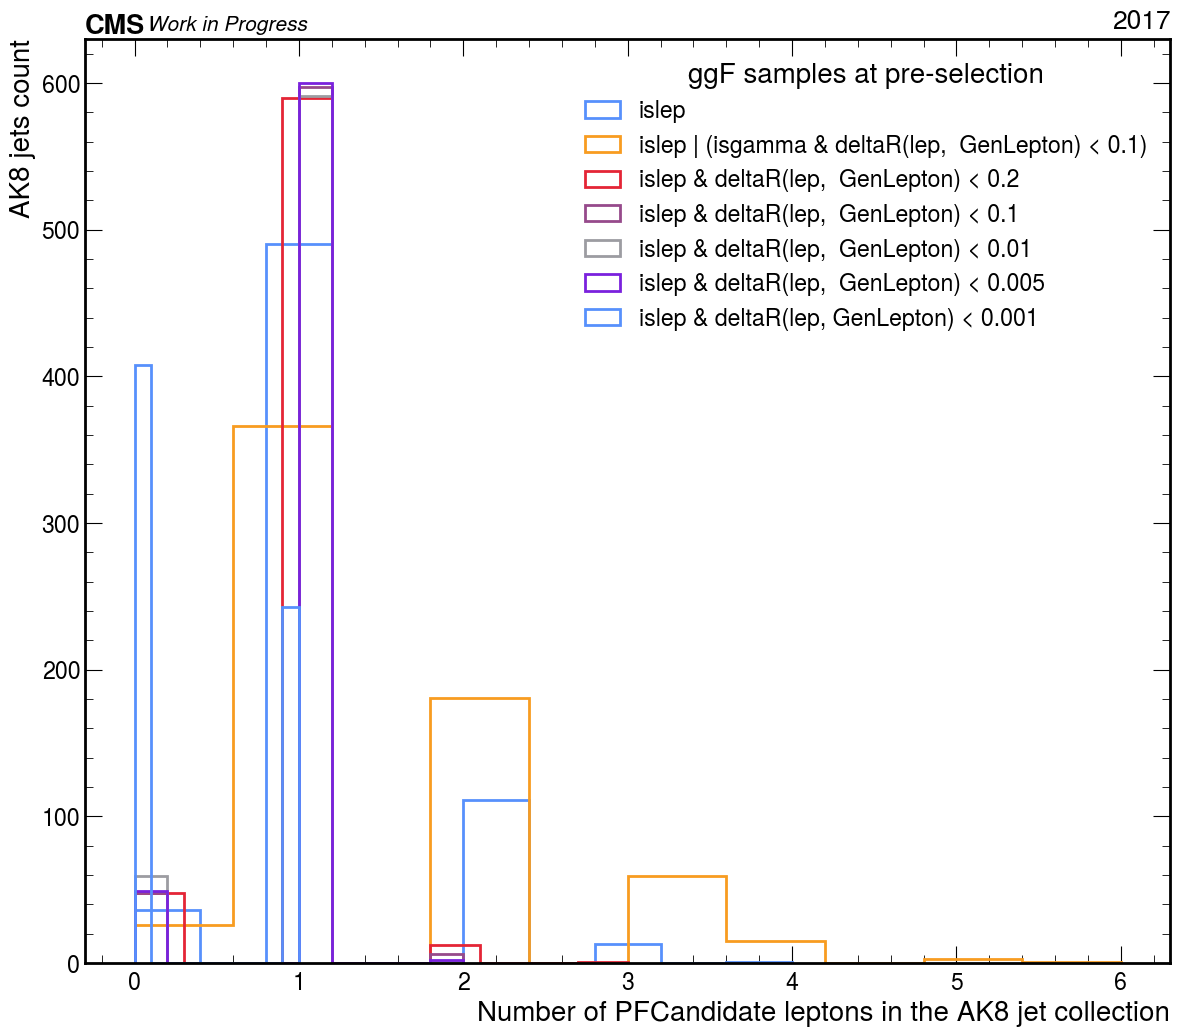

In [168]:
plt.rcParams.update({"font.size": 20})
### save plot
fig, ax = plt.subplots(figsize=(14, 12))

ax.hist((msk_lep).sum(axis=1), label="islep", histtype="step", lw=2)
ax.hist((msk_lep | msk_gamma).sum(axis=1), label="islep | (isgamma & deltaR(lep,  GenLepton) < 0.1)", histtype="step", lw=2)

ax.hist((msk_lep & (delta_r < 0.2)).sum(axis=1), label="islep & deltaR(lep,  GenLepton) < 0.2", histtype="step", lw=2)
ax.hist((msk_lep & (delta_r < 0.1)).sum(axis=1), label="islep & deltaR(lep,  GenLepton) < 0.1", histtype="step", lw=2)
ax.hist((msk_lep & (delta_r < 0.01)).sum(axis=1), label="islep & deltaR(lep,  GenLepton) < 0.01", histtype="step", lw=2)
ax.hist((msk_lep & (delta_r < 0.05)).sum(axis=1), label="islep & deltaR(lep,  GenLepton) < 0.005", histtype="step", lw=2)
ax.hist((msk_lep & (delta_r < 0.001)).sum(axis=1), label="islep & deltaR(lep, GenLepton) < 0.001", histtype="step", lw=2)

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.legend(title=f"ggF samples at pre-selection")
ax.set_ylabel(r"AK8 jets count"); 
ax.set_xlabel(r"Number of PFCandidate leptons in the AK8 jet collection");
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'),
 supptext: Custom Text(1.012, 1, ''))

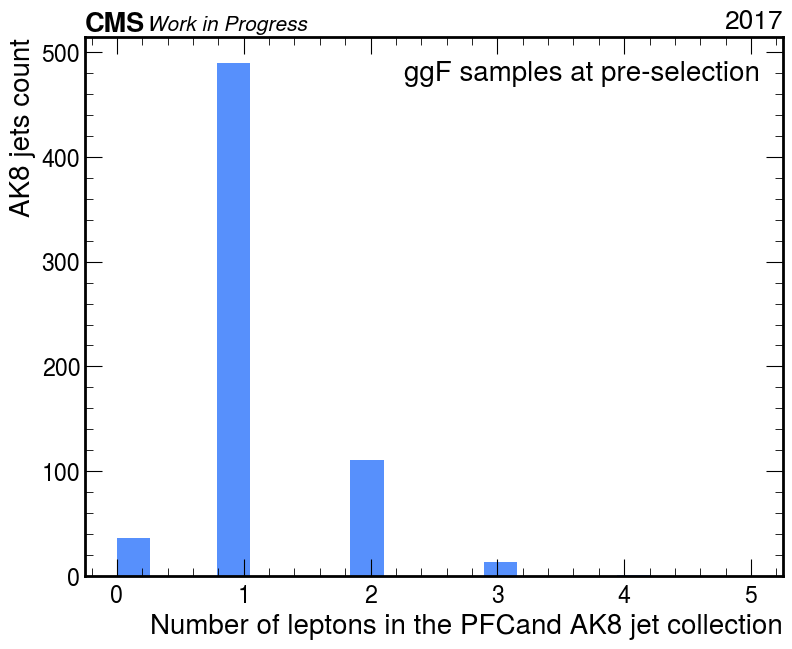

In [153]:
plt.rcParams.update({"font.size": 20})
### save plot
fig, ax = plt.subplots(figsize=(9, 7))
ax.hist(
    ak.sum(msk_lep, axis=1),
    bins=np.linspace(0,5,20)
)

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.legend(title=f"ggF samples at pre-selection")
ax.set_ylabel(r"AK8 jets count"); 
ax.set_xlabel(r"Number of leptons in the PFCand AK8 jet collection");
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

In [154]:
islep = (jet_pfcand.pdgId == ELE_PDGID) | (jet_pfcand.pdgId == MU_PDGID) | (jet_pfcand.pdgId == TAU_PDGID)

jet_pfcand[islep]

<NanoCollectionArray [[{d0: -0.00114, ... trkQuality: 5}]] type='651 * option[va...'>

In [155]:
idx_lep = ak.argmin(candidatelep_p4.delta_r(jet_pfcand[islep]), axis=1, keepdims=True)
idx_lep

<Array [[0], [0], [0], ... [None], [0], [0]] type='651 * option[var * ?int64]'>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'),
 supptext: Custom Text(1.012, 1, ''))

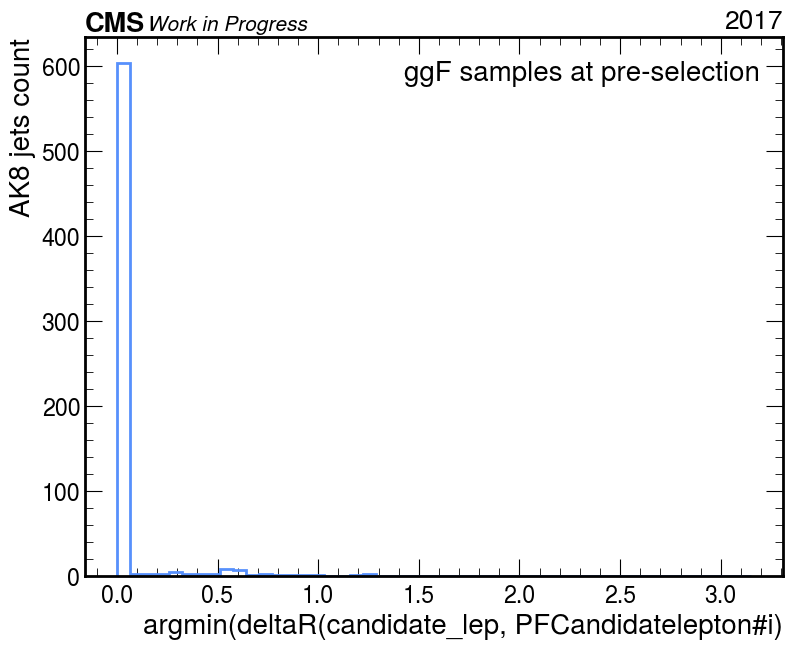

In [160]:
plt.rcParams.update({"font.size": 20})
### save plot
fig, ax = plt.subplots(figsize=(9, 7))
ax.hist(
    ak.flatten(candidatelep_p4.delta_r(jet_pfcand[islep])[idx_lep]),
    bins=np.linspace(0,3.15,50),
    histtype="step",
    lw=2,
)

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.legend(title=f"ggF samples at pre-selection")
ax.set_ylabel(r"AK8 jets count"); 
ax.set_xlabel(r"argmin(deltaR(candidate_lep, PFCandidatelepton#i)");
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

<NanoCollectionArray [[{d0: -0.00114, ... trkQuality: 5}]] type='651 * var * str...'>

<Array [[1.53e-05], [0], [0, ... [0], [0]] type='651 * option[var * ?float32]'>

<Array [[False, False, ... False, False]] type='651 * var * bool'>

(array([  8.,   3.,   0., 357.,   0.,  54.,   0., 153.,   0.,  22.,   0.,
         33.,   0.,   4.,   0.,  11.,   0.,   0.,   5.]),
 array([ 0.        ,  0.52631579,  1.05263158,  1.57894737,  2.10526316,
         2.63157895,  3.15789474,  3.68421053,  4.21052632,  4.73684211,
         5.26315789,  5.78947368,  6.31578947,  6.84210526,  7.36842105,
         7.89473684,  8.42105263,  8.94736842,  9.47368421, 10.        ]),
 <BarContainer object of 19 artists>)

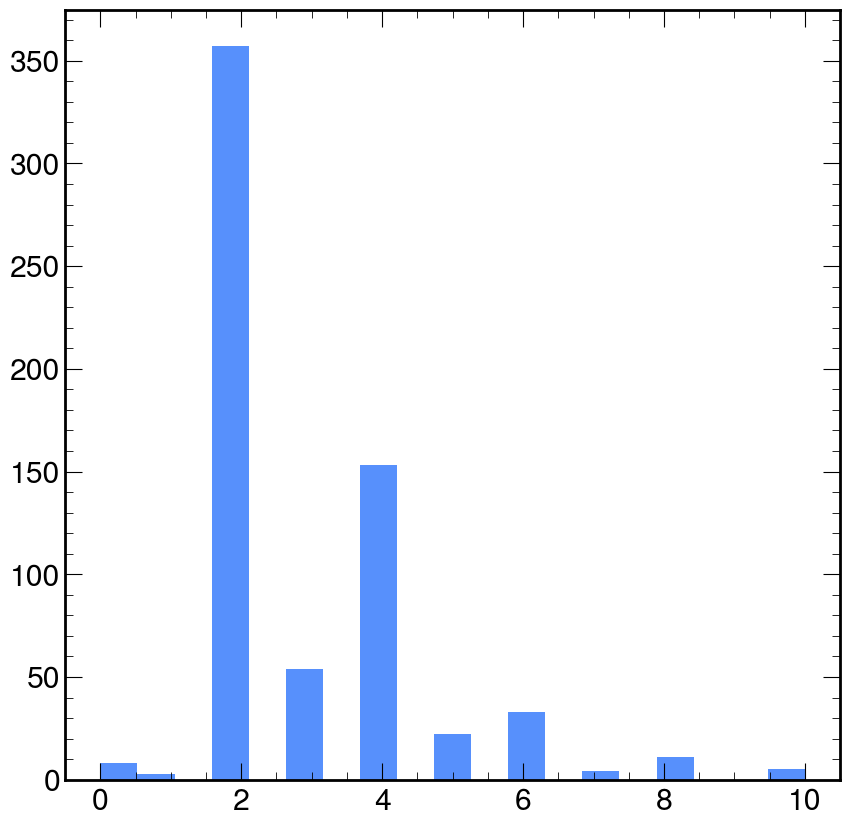

In [15]:
        higgs = ak.firsts(genparts[get_pid_mask(genparts, HIGGS_PDGID, byall=False) * genparts.hasFlags(GEN_FLAGS)])

        children_mask = get_pid_mask(higgs.children, [W_PDGID], byall=False)

        # order by mass, select lower mass child as V* and higher as V
        higgs_children = higgs.children[children_mask]

        # VV daughters
        # requires coffea-0.7.21
        all_daus = higgs_children.distinctChildrenDeep  # TODO: double check it's always 4
        all_daus_flat = ak.flatten(all_daus, axis=2)  # flattents the daughters of the two Ws
        all_daus_flat_pdgId = abs(all_daus_flat.pdgId)

        # the following tells you about the matching
        leptons = (all_daus_flat_pdgId == ELE_PDGID) | (all_daus_flat_pdgId == MU_PDGID) | (all_daus_flat_pdgId == TAU_PDGID)

        lepVars = {
            "lepton_pt": all_daus_flat[leptons].pt,
            "lepton_eta": all_daus_flat[leptons].eta,
            "lepton_phi": all_daus_flat[leptons].phi,
            "lepton_mass": all_daus_flat[leptons].mass,
        }

        quarkVars = {
            "quark_pt": all_daus_flat[all_daus_flat_pdgId <= b_PDGID].pt,
            "quark_eta": all_daus_flat[all_daus_flat_pdgId <= b_PDGID].eta,
            "quark_phi": all_daus_flat[all_daus_flat_pdgId <= b_PDGID].phi,
            "quark_mass": all_daus_flat[all_daus_flat_pdgId <= b_PDGID].mass,
        }

/Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/coffea/nanoevents/methods/nanoaod.py:107: UserWarning: distinctChildrenDeep may not give correct answers for all generators!
  warnings.warn(


In [25]:

    ak8_jets = np.array(
        np.stack(
            (np.array(candidatefj.pt), np.array(candidatefj.eta), np.array(candidatefj.phi), np.array(candidatefj.mass)),
            axis=1,
        )  # four vector for HWW jet
    )

    skim_vars = {
        "eta": "Eta",
        "phi": "Phi",
        "mass": "Mass",
        "pt": "Pt",
    }

    Gen2qVars = {
        f"Gen2q{var}": ak.to_numpy(
            ak.fill_none(
                ak.pad_none(quarkVars[f"quark_{key}"], 2, axis=1, clip=True),
                FILL_NONE_VALUE,
            )
        )
        for key, var in skim_vars.items()
    }

    # prepare eta, phi array only for 2q, used for Lund Plane reweighting
    # since it only takes quarks gen-level 4-vector as input
    eta_2q = Gen2qVars["Gen2qEta"]
    phi_2q = Gen2qVars["Gen2qPhi"]
    gen_parts_eta_phi = np.array(np.dstack((eta_2q, phi_2q)))

    GenlepVars = {
        f"Genlep{var}": ak.to_numpy(
            ak.fill_none(
                ak.pad_none(lepVars[f"lepton_{key}"], 1, axis=1, clip=True),
                FILL_NONE_VALUE,
            )
        )
        for key, var in skim_vars.items()
    }

    # PF candidates in the AK8 jet
    HWW_FatJetPFCands = events.FatJetPFCands.jetIdx == ak.firsts(fj_idx_lep)
    HWW_FatJetPFCands_pFCandsIdx = events.FatJetPFCands.pFCandsIdx[HWW_FatJetPFCands]

    pt_array = ak.Array(events.PFCands.pt)
    eta_array = ak.Array(events.PFCands.eta)
    phi_array = ak.Array(events.PFCands.phi)
    mass_array = ak.Array(events.PFCands.mass)


In [26]:
    # Need to clean PFCands with dR(l,pf)<0.2
    lep_eta = GenlepVars["GenlepEta"]
    lep_phi = GenlepVars["GenlepPhi"]

    # this is because the length of PFCands can be up to 409, so we pad to target = 500
    pf_eta = pad_val(eta_array, target=500, axis=1, value=0)
    pf_phi = pad_val(phi_array, target=500, axis=1, value=0)
    pf_pt = pad_val(pt_array, target=500, axis=1, value=0)
    pf_mass = pad_val(mass_array, target=500, axis=1, value=0)

    lep_eta_reshaped = lep_eta.reshape(-1, 1)
    lep_phi_reshaped = lep_phi.reshape(-1, 1)

    delta_eta = lep_eta_reshaped - pf_eta
    delta_phi = lep_phi_reshaped - pf_phi

    delta_r = np.sqrt(delta_eta**2 + delta_phi**2)

    pf_eta_rm_lep = np.copy(pf_eta)
    pf_phi_rm_lep = np.copy(pf_phi)
    pf_pt_rm_lep = np.copy(pf_pt)
    pf_mass_rm_lep = np.copy(pf_mass)

    pf_eta_rm_lep[delta_r < 0.1] = 0.0
    pf_phi_rm_lep[delta_r < 0.1] = 0.0
    pf_pt_rm_lep[delta_r < 0.1] = 0.0
    pf_mass_rm_lep[delta_r < 0.1] = 0.0


In [62]:
pdg = pad_val(ak.Array(events.PFCands.pdgId), target=500, axis=1, value=0)
pdg.shape

(651, 500)

In [74]:
np.unique(abs(pdg)[delta_r<0.001], return_counts=True)

(array([ 11,  13, 211]), array([ 80, 432,  12]))

In [77]:
(delta_r < 0.01).sum(axis=1)

masked_array(data=[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2,
                   2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                   2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2,
                   2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                   2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2,
                   2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                   2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 0, 2, 2, 2, 2, 2, 2, 2,
                   2, 2, 4, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 4,
                   2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                   4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                   2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2,
                   2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
                   2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
                   2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [78]:
lep_eta

masked_array(
  data=[[-4.65087891e-02],
        [ 1.03125000e+00],
        [ 1.07421875e+00],
        [ 9.15527344e-02],
        [ 9.74609375e-01],
        [-4.05273438e-01],
        [ 7.10937500e-01],
        [-3.53515625e-01],
        [-1.08593750e+00],
        [-3.20312500e-01],
        [ 8.43750000e-01],
        [ 1.15625000e+00],
        [ 1.36328125e+00],
        [ 1.46875000e+00],
        [-4.67773438e-01],
        [-1.07812500e+00],
        [ 9.90234375e-01],
        [-7.20703125e-01],
        [-1.77734375e+00],
        [-2.04101562e-01],
        [-1.10937500e+00],
        [-6.77734375e-01],
        [-1.25390625e+00],
        [ 1.12915039e-02],
        [ 1.60546875e+00],
        [-5.40771484e-02],
        [ 8.26171875e-01],
        [ 7.28515625e-01],
        [ 6.91406250e-01],
        [ 5.13671875e-01],
        [ 2.29003906e-01],
        [ 1.70898438e-01],
        [-9.25781250e-01],
        [-1.59375000e+00],
        [-6.56250000e-01],
        [ 1.42578125e-01],
        [ 4.77

In [116]:
HWW_FatJetPFCands = events.FatJetPFCands.jetIdx == ak.firsts(fj_idx_lep)
HWW_FatJetPFCands_pFCandsIdx = events.FatJetPFCands.pFCandsIdx[HWW_FatJetPFCands]


islep = (
    (ak.Array(abs(events.PFCands.pdgId)) == ELE_PDGID)
    | (ak.Array(abs(events.PFCands.pdgId)) == MU_PDGID)
    | (ak.Array(abs(events.PFCands.pdgId)) == TAU_PDGID)
)

eta_array = ak.Array(events.PFCands.eta)
eta_array[~islep][HWW_FatJetPFCands_pFCandsIdx]

<Array [[0.1, 0.0934, 0.296, ... 1.65, -0.276]] type='651 * option[var * float32...'>

In [103]:
HWW_FatJetPFCands_pFCandsIdx

<Array [[0, 1, 2, 7, 20, ... 41, 42, 7, 36]] type='651 * option[var * int32[para...'>

In [ ]:
    candidatefj = candidatefj - candidatelep_p4

    lepVars, quarkVars = getGenLepGenQuarks(dataset, events.GenPart)

    ak8_jets = np.array(
        np.stack(
            (np.array(candidatefj.pt), np.array(candidatefj.eta), np.array(candidatefj.phi), np.array(candidatefj.mass)),
            axis=1,
        )  # four vector for HWW jet
    )

    skim_vars = {
        "eta": "Eta",
        "phi": "Phi",
        "mass": "Mass",
        "pt": "Pt",
    }

    Gen2qVars = {
        f"Gen2q{var}": ak.to_numpy(
            ak.fill_none(
                ak.pad_none(quarkVars[f"quark_{key}"], 2, axis=1, clip=True),
                FILL_NONE_VALUE,
            )
        )
        for key, var in skim_vars.items()
    }

    # prepare eta, phi array only for 2q, used for Lund Plane reweighting
    # since it only takes quarks gen-level 4-vector as input
    eta_2q = Gen2qVars["Gen2qEta"]
    phi_2q = Gen2qVars["Gen2qPhi"]
    gen_parts_eta_phi = np.array(np.dstack((eta_2q, phi_2q)))

    GenlepVars = {
        f"Genlep{var}": ak.to_numpy(
            ak.fill_none(
                ak.pad_none(lepVars[f"lepton_{key}"], 1, axis=1, clip=True),
                FILL_NONE_VALUE,
            )
        )
        for key, var in skim_vars.items()
    }

    # PF candidates in the AK8 jet
    HWW_FatJetPFCands = events.FatJetPFCands.jetIdx == ak.firsts(fj_idx_lep)
    HWW_FatJetPFCands_pFCandsIdx = events.FatJetPFCands.pFCandsIdx[HWW_FatJetPFCands]

    pt_array = ak.Array(events.PFCands.pt)
    eta_array = ak.Array(events.PFCands.eta)
    phi_array = ak.Array(events.PFCands.phi)
    mass_array = ak.Array(events.PFCands.mass)

    pf_cands_px, pf_cands_py, pf_cands_pz, pf_cands_E = lep_removal(
        events, pt_array, eta_array, phi_array, mass_array, GenlepVars, HWW_FatJetPFCands_pFCandsIdx
    )
    pf_cands = np.dstack((pf_cands_px, pf_cands_py, pf_cands_pz, pf_cands_E))


In [23]:
genVars

{'fj_genH_pt': <Array [313, 390, 332, 326, ... 424, 321, 263] type='651 * float64'>,
 'fj_genH_jet': <Array [0.107, 0.102, 0.11, ... 0.0306, 0.165] type='651 * ?float32'>,
 'fj_genV_dR': <Array [0.188, 0.0778, 0.124, ... 0.142, 0.178] type='651 * ?float32'>,
 'fj_genVstar': <Array [0.307, 0.142, 0.0812, ... 0.245, 0.328] type='651 * ?float32'>,
 'genV_genVstar_dR': <Array [0.448, 0.114, 0.0559, ... 0.386, 0.378] type='651 * ?float32'>,
 'fj_isHVV': <Array [True, True, True, ... True, True, True] type='651 * ?bool'>,
 'fj_isHVV_Matched': <Array [True, True, True, ... True, True, True] type='651 * ?bool'>,
 'fj_isHVV_4q': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='651 * ?int32'>,
 'fj_isHVV_elenuqq': <Array [1, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='651 * ?int32'>,
 'fj_isHVV_munuqq': <Array [0, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='651 * ?int32'>,
 'fj_isHVV_taunuqq': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='651 * ?int32'>,
 'fj_isHVV_Vlepton': <Array [T

In [24]:
genVars["fj_nquarks"]

<Array [1, 1, 1, 1, 3, 2, ... 2, 2, 1, 2, 2, 1] type='651 * ?int64'>

In [12]:
# load a hww root file into coffea-friendly NanoAOD structure
import uproot
f = uproot.open(f"../rootfiles/HWW/file1.root")

num = f['Events'].num_entries   ### checks number of events per file 
print(f'number of events per file is {num}')

events = nanoevents.NanoEventsFactory.from_root(f, "Events").events()
events

number of events per file is 15000


<NanoEventsArray [<event 1:100:99001>, ... ] type='15000 * event'>

In [18]:
for key in events.fields:
    print(key)

fixedGridRhoFastjetAll
TkMET
L1simulation
LHEReweightingWeight
Tau
FatJetAK15SubJet
IsoTrack
fixedGridRhoFastjetCentralChargedPileUp
FatJetPFCands
DeepMETResponseTune
Pileup
luminosityBlock
LHEPdfWeight
SoftActivityJetHT2
SoftActivityJetHT5
SoftActivityJetHT
SV
SoftActivityJetNjets2
SoftActivityJetNjets5
Jet
fixedGridRhoFastjetCentralNeutral
FatJetAK15PFCands
SoftDropGenJetAK8
PFCands
OtherPV
PV
TrigObj
HLT
Generator
GenVisTau
RawMET
GenJet
fixedGridRhoFastjetCentral
LHE
genWeight
SoftActivityJet
GenSubJetAK15
genTtbarId
DeepMETResolutionTune
GenJetAK8
boostedTau
GenVtx
Photon
Flag
FatJet
L1PreFiringWeight
run
PuppiMET
GenDressedLepton
SubGenJetAK8
HLTriggerFirstPath
HLTriggerFinalPath
LowPtElectron
GenJetAK15
CaloMET
FatJetSVs
CorrT1METJet
FsrPhoton
SubJet
RawPuppiMET
LHEWeight
GenIsolatedPhoton
Muon
MET
PSWeight
GenPart
SoftDropGenJetAK15
ChsMET
LHEScaleWeight
FatJetAK15
L1
btagWeight
fixedGridRhoFastjetCentralCalo
event
LHEPart
SoftActivityJetNjets10
L1Reco
SoftActivityJetHT10
JetSV

In [20]:
def get_pid_mask(
    genparts: GenParticleArray,
    pdgids: Union[int, list],
    ax: int = 2,
    byall: bool = True,
) -> ak.Array:
    """
    Get selection mask for gen particles matching any of the pdgIds in ``pdgids``.
    If ``byall``, checks all particles along axis ``ax`` match.
    """
    gen_pdgids = abs(genparts.pdgId)

    if type(pdgids) is list:
        mask = gen_pdgids == pdgids[0]
        for pdgid in pdgids[1:]:
            mask = mask | (gen_pdgids == pdgid)
    else:
        mask = gen_pdgids == pdgids

    return ak.all(mask, axis=ax) if byall else mask


def to_label(array: ak.Array) -> ak.Array:
    return ak.values_astype(array, np.int32)

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]


genparts = events.GenPart
HIGGS_PDGID = 25

higgs = genparts[get_pid_mask(genparts, HIGGS_PDGID, byall=False) * genparts.hasFlags(GEN_FLAGS)]

In [21]:
higgs

<GenParticleArray [[GenParticle], ... [GenParticle]] type='15000 * var * genPart...'>

In [96]:
d_PDGID = 1
c_PDGID = 4
b_PDGID = 5
g_PDGID = 21
TOP_PDGID = 6

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

GAMMA_PDGID = 22
Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25

PI_PDGID = 211
PO_PDGID = 221
PP_PDGID = 111

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

FILL_NONE_VALUE = -99999

JET_DR = 0.8


def match_H(genparts: GenParticleArray, fatjet: FatJetArray):
    """Gen matching for Higgs samples.

    An edited version of the function that returns the genquark info that is useful for LP method.
    """

    higgs = ak.firsts(genparts[get_pid_mask(genparts, HIGGS_PDGID, byall=False) * genparts.hasFlags(GEN_FLAGS)])
    matched_higgs_mask = fatjet.delta_r(higgs) < 0.8

    children_mask = get_pid_mask(higgs.children, [W_PDGID], byall=False)
    is_hww = ak.any(children_mask, axis=1)

    # order by mass, select lower mass child as V* and higher as V
    higgs_children = higgs.children[children_mask]
    children_mass = higgs_children.mass
    v_star = ak.firsts(higgs_children[ak.argmin(children_mass, axis=1, keepdims=True)])
    v = ak.firsts(higgs_children[ak.argmax(children_mass, axis=1, keepdims=True)])

    # VV daughters
    # requires coffea-0.7.21
    all_daus = higgs_children.distinctChildrenDeep
    all_daus_flat = ak.flatten(all_daus, axis=2)  # flattents the daughters of the two Ws
    all_daus_flat_pdgId = abs(all_daus_flat.pdgId)

    # the following tells you about the decay
    num_quarks = ak.sum(all_daus_flat_pdgId <= b_PDGID, axis=1)
    num_leptons = ak.sum(
        (all_daus_flat_pdgId == ELE_PDGID) | (all_daus_flat_pdgId == MU_PDGID) | (all_daus_flat_pdgId == TAU_PDGID),
        axis=1,
    )
    num_electrons = ak.sum(all_daus_flat_pdgId == ELE_PDGID, axis=1)
    num_muons = ak.sum(all_daus_flat_pdgId == MU_PDGID, axis=1)
    num_taus = ak.sum(all_daus_flat_pdgId == TAU_PDGID, axis=1)

    # the following tells you about the matching
    # prongs except neutrino
    neutrinos = (
        (all_daus_flat_pdgId == vELE_PDGID) | (all_daus_flat_pdgId == vMU_PDGID) | (all_daus_flat_pdgId == vTAU_PDGID)
    )

    leptons = (all_daus_flat_pdgId == ELE_PDGID) | (all_daus_flat_pdgId == MU_PDGID) | (all_daus_flat_pdgId == TAU_PDGID)

    # num_m: number of matched leptons
    # number of quarks excludes neutrino and leptons
    num_m_quarks = ak.sum(fatjet.delta_r(all_daus_flat[~neutrinos & ~leptons]) < JET_DR, axis=1)
    num_m_leptons = ak.sum(fatjet.delta_r(all_daus_flat[leptons]) < JET_DR, axis=1)
    num_m_cquarks = ak.sum(fatjet.delta_r(all_daus_flat[all_daus_flat.pdgId == b_PDGID]) < JET_DR, axis=1)

    lep_daughters = all_daus_flat[leptons]
    # parent = ak.firsts(lep_daughters[fatjet.delta_r(lep_daughters) < JET_DR].distinctParent)
    parent = ak.firsts(lep_daughters.distinctParent)
    
    iswlepton = parent.mass == v.mass
    iswstarlepton = parent.mass == v_star.mass
    
    genVars = {"fj_genH_pt": ak.fill_none(higgs.pt, FILL_NONE_VALUE)}

    genVVars = {
        "fj_genH_jet": fatjet.delta_r(higgs),
        "fj_genV_dR": fatjet.delta_r(v),
        "fj_genVstar": fatjet.delta_r(v_star),
        "genV_genVstar_dR": v.delta_r(v_star),
    }

    genHVVVars = {
        "fj_isHVV": is_hww,
        "fj_isHVV_Matched": matched_higgs_mask,
        "fj_isHVV_4q": to_label((num_quarks == 4) & (num_leptons == 0)),
        "fj_isHVV_elenuqq": to_label((num_electrons == 1) & (num_quarks == 2) & (num_leptons == 1)),
        "fj_isHVV_munuqq": to_label((num_muons == 1) & (num_quarks == 2) & (num_leptons == 1)),
        "fj_isHVV_taunuqq": to_label((num_taus == 1) & (num_quarks == 2) & (num_leptons == 1)),
        "fj_isHVV_Vlepton": iswlepton,
        "fj_isHVV_Vstarlepton": iswstarlepton,
        "fj_genRes_mass": higgs.mass,
        "fj_nquarks": num_m_quarks,
        "fj_ncquarks": num_m_cquarks,
        "fj_lepinprongs": num_m_leptons,
        "lep_daughters": leptons,
        "all_daus": all_daus,
    }

    lepVars = {
        "lepton_pt": all_daus_flat[leptons].pt,
        "lepton_eta": all_daus_flat[leptons].eta,
        "lepton_phi": all_daus_flat[leptons].phi,
        "lepton_mass": all_daus_flat[leptons].mass,
    }

    quarkVars = {
        "quark_pt": all_daus_flat[all_daus_flat_pdgId <= b_PDGID].pt,
        "quark_eta": all_daus_flat[all_daus_flat_pdgId <= b_PDGID].eta,
        "quark_phi": all_daus_flat[all_daus_flat_pdgId <= b_PDGID].phi,
        "quark_mass": all_daus_flat[all_daus_flat_pdgId <= b_PDGID].mass,
    }

    genVars = {**genVars, **genVVars, **genHVVVars, **lepVars, **quarkVars}

    return genVars

In [175]:
def build_p4(cand):
    return ak.zip(
        {
            "pt": cand.pt,
            "eta": cand.eta,
            "phi": cand.phi,
            "mass": cand.mass,
            "charge": cand.charge,
        },
        with_name="PtEtaPhiMCandidate",
        behavior=candidate.behavior,
    )

# lepton
electrons = events["Electron"][events["Electron"].pt > 40]
muons = events["Muon"][events["Muon"].pt > 30]
leptons = ak.concatenate([electrons, muons], axis=1)
leptons = leptons[ak.argsort(leptons.pt, ascending=False)]
candidatelep = ak.firsts(leptons)
candidatelep_p4 = build_p4(candidatelep)

# fatjet
fatjets = events["FatJet"]
good_fatjets = (fatjets.pt > 200) & (abs(fatjets.eta) < 2.5) & fatjets.isTight

good_fatjets = fatjets[good_fatjets]  # select good fatjets
good_fatjets = good_fatjets[ak.argsort(good_fatjets.pt, ascending=False)]  # sort them by pt

# candidatefj
fj_idx_lep = ak.argmin(good_fatjets.delta_r(candidatelep_p4), axis=1, keepdims=True)
candidatefj = ak.firsts(good_fatjets[fj_idx_lep])

genVars = match_H(events.GenPart, candidatefj)

In [164]:
candidatefj

<FatJetArray [FatJet, None, None, ... None, FatJet] type='15000 * ?fatJet'>

In [173]:
~ak.is_none(candidatefj)

<Array [True, False, False, ... False, True] type='15000 * bool'>

In [174]:
~ak.is_none(candidatelep_p4)

<Array [True, True, True, ... True, True, True] type='15000 * bool'>

In [98]:
genVars

{'fj_genH_pt': <Array [283, 249, 240, 273, ... 270, 244, 347] type='15000 * float64'>,
 'fj_genH_jet': <Array [3.33, None, None, ... None, None, 2.71] type='15000 * ?float32'>,
 'fj_genV_dR': <Array [3.35, None, None, ... None, None, 2.69] type='15000 * ?float32'>,
 'fj_genVstar': <Array [3.32, None, None, ... None, None, 2.73] type='15000 * ?float32'>,
 'genV_genVstar_dR': <Array [0.205, 0.668, 0.106, ... 1.13, 0.0656] type='15000 * ?float32'>,
 'fj_isHVV': <Array [True, True, True, ... True, True, True] type='15000 * ?bool'>,
 'fj_isHVV_Matched': <Array [False, None, None, ... None, False] type='15000 * ?bool'>,
 'fj_isHVV_4q': <Array [0, 0, 1, 0, 1, 0, ... 1, 1, 0, 1, 1, 0] type='15000 * ?int32'>,
 'fj_isHVV_elenuqq': <Array [1, 0, 0, 0, 0, 1, ... 0, 0, 0, 0, 0, 0] type='15000 * ?int32'>,
 'fj_isHVV_munuqq': <Array [0, 0, 0, 1, 0, 0, ... 0, 0, 1, 0, 0, 0] type='15000 * ?int32'>,
 'fj_isHVV_taunuqq': <Array [0, 1, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 1] type='15000 * ?int32'>,
 'fj_isHVV_V

In [99]:
msk = genVars["fj_isHVV_Matched"]
msk

<Array [False, None, None, ... None, False] type='15000 * ?bool'>

In [100]:
a = genVars["fj_nquarks"][msk]
a[~ak.is_none(a)]

<Array [1, 3, 4, 2, 1, 2, ... 2, 1, 1, 1, 1, 1] type='2773 * ?int64'>

In [85]:
genparts = events.GenPart
fatjet = candidatefj

In [86]:
higgs = ak.firsts(genparts[get_pid_mask(genparts, HIGGS_PDGID, byall=False) * genparts.hasFlags(GEN_FLAGS)])
print(higgs.type)

15000 * ?genParticle


In [87]:
matched_higgs_mask = fatjet.delta_r(higgs) < 0.8
print(matched_higgs_mask.type)

15000 * ?bool


In [88]:
matched_higgs = higgs[matched_higgs_mask]
matched_higgs.type

12036 * ?genParticle

In [89]:
children_mask = get_pid_mask(higgs.children, [W_PDGID], byall=False)
is_hww = ak.any(children_mask, axis=1)

# order by mass, select lower mass child as V* and higher as V
children_mass = higgs_children.mass
v_star = ak.firsts(higgs_children[ak.argmin(children_mass, axis=1, keepdims=True)])
v = ak.firsts(higgs_children[ak.argmax(children_mass, axis=1, keepdims=True)])

print(is_hww.type)
print(v.type)

15000 * ?bool
15000 * ?genParticle


In [158]:
# candidatefj is the jet closest to the lepton

higgs = ak.firsts(genparts[get_pid_mask(genparts, HIGGS_PDGID, byall=False) * genparts.hasFlags(GEN_FLAGS)])
matched_higgs_mask = candidatefj.delta_r(higgs) < 0.8

children_mask = get_pid_mask(higgs.children, [W_PDGID], byall=False)
higgs_children = higgs.children[children_mask]

all_daus = higgs_children.distinctChildrenDeep
all_daus_flat = ak.flatten(all_daus, axis=2)  # flattens the daughters of the two Ws
all_daus_flat_pdgId = abs(all_daus_flat.pdgId)

isquark = all_daus_flat_pdgId <= b_PDGID

# number of quarks excludes neutrino and leptons
num_quarks = ak.sum(isquark, axis=1)

# number of quarks excludes neutrino and leptons that are within 0.8
num_m_quarks = ak.sum(candidatefj.delta_r(all_daus_flat[isquark]) < JET_DR, axis=1)

In [159]:
# apply matching (i.e. deltaR(higgs, jet)<0.8)
a = num_quarks[matched_higgs_mask]
np.unique(a[~ak.is_none(a)], return_counts=True)

(array([0, 2, 4]), array([ 287, 1792,  694]))

In [160]:
# apply matching (i.e. deltaR(higgs, jet)<0.8)
a = num_m_quarks[matched_higgs_mask]
np.unique(a[~ak.is_none(a)], return_counts=True)

(array([0, 1, 2, 3, 4]), array([ 313,  870, 1081,  353,  156]))

In [2]:
d_PDGID = 1
c_PDGID = 4
b_PDGID = 5
g_PDGID = 21
TOP_PDGID = 6

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

GAMMA_PDGID = 22
Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25

PI_PDGID = 211
PO_PDGID = 221
PP_PDGID = 111

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

FILL_NONE_VALUE = -99999

JET_DR = 0.8


btagWPs = {
    "deepJet": {
        "2016APV": {
            "L": 0.0508,
            "M": 0.2598,
            "T": 0.6502,
        },
        "2016": {
            "L": 0.0480,
            "M": 0.2489,
            "T": 0.6377,
        },
        "2017": {
            "L": 0.0532,
            "M": 0.3040,
            "T": 0.7476,
        },
        "2018": {
            "L": 0.0490,
            "M": 0.2783,
            "T": 0.7100,
        },
    },
    "deepCSV": {
        "2016APV": {
            "L": 0.2027,
            "M": 0.6001,
            "T": 0.8819,
        },
        "2016": {
            "L": 0.1918,
            "M": 0.5847,
            "T": 0.8767,
        },
        "2017": {
            "L": 0.1355,
            "M": 0.4506,
            "T": 0.7738,
        },
        "2018": {
            "L": 0.1208,
            "M": 0.4168,
            "T": 0.7665,
        },
    },
}

In [3]:
year = "2018"

In [4]:

        # ak4 jets
        ak4_jet_selector_no_btag = (
            (events.Jet.pt > 30) & (abs(events.Jet.eta) < 5.0) & events.Jet.isTight & (events.Jet.puId > 0)
        )


        goodjets = events.Jet[ak4_jet_selector_no_btag]
        ht = ak.sum(goodjets.pt, axis=1)

        dr_jet_lepfj = goodjets.delta_r(candidatefj)
        ak4_outside_ak8 = goodjets[dr_jet_lepfj > 0.8]
        NumOtherJets = ak.num(ak4_outside_ak8)

        # VBF variables
        jet1 = ak4_outside_ak8[:, 0:1]
        jet2 = ak4_outside_ak8[:, 1:2]
        deta = abs(ak.firsts(jet1).eta - ak.firsts(jet2).eta)
        mjj = (ak.firsts(jet1) + ak.firsts(jet2)).mass
        jj_pt = (ak.firsts(jet1) + ak.firsts(jet2)).pt

        # rec_higgs
        candidateNeutrino = ak.zip(
            {
                "pt": met.pt,
                "eta": candidatelep_p4.eta,
                "phi": met.phi,
                "mass": 0,
                "charge": 0,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )
        rec_W_lnu = candidatelep_p4 + candidateNeutrino
        rec_W_qq = candidatefj - candidatelep_p4
        rec_higgs = rec_W_qq + rec_W_lnu

        # INPUT VARIABLES
        # CANDIDATE JET
        fj_vars = [
                "eta",
                "phi",
                "mass",
                "pt",
                "msoftdrop",
                "lsf3",
            ]
        

        FatJetVars = {f"fj_{var}": ak.fill_none(candidatefj[var], FILL_NONE_VALUE) for var in fj_vars}

        # CANDIDATE LEPTON
        LepVars = {}
        LepVars["lep_dR_fj"] = candidatelep_p4.delta_r(candidatefj).to_numpy().filled(fill_value=0)
        LepVars["lep_pt"] = (candidatelep_p4.pt).to_numpy().filled(fill_value=0)
        LepVars["lep_pt_ratio"] = (candidatelep_p4.pt / candidatefj.pt).to_numpy().filled(fill_value=0)
        LepVars["lep_reliso"] = lep_reliso.to_numpy().filled(fill_value=0)
        LepVars["lep_miso"] = lep_miso.to_numpy().filled(fill_value=0)

        # MET
        METVars = {}
        METVars["met_pt"] = met.pt
        METVars["met_relpt"] = met.pt / candidatefj.pt
        METVars["met_fj_dphi"] = met.delta_phi(candidatefj)
        METVars["abs_met_fj_dphi"] = np.abs(met.delta_phi(candidatefj))
        METVars["mt_lep_met"] = mt_lep_met.to_numpy().filled(fill_value=0)

        # OTHERS

        # bjet
        Others = {}
        Others["n_bjets_L"] = (
            ak.sum(ak4_outside_ak8.btagDeepFlavB > btagWPs["deepJet"][year]["L"], axis=1)
            .to_numpy()
            .filled(fill_value=0)
        )
        Others["n_bjets_M"] = (
            ak.sum(ak4_outside_ak8.btagDeepFlavB > btagWPs["deepJet"][year]["M"], axis=1)
            .to_numpy()
            .filled(fill_value=0)
        )
        Others["n_bjets_T"] = (
            ak.sum(ak4_outside_ak8.btagDeepFlavB > btagWPs["deepJet"][year]["T"], axis=1)
            .to_numpy()
            .filled(fill_value=0)
        )

        # RECONSTRUCTED MASS
        Others["rec_W_lnu_pt"] = rec_W_lnu.pt.to_numpy().filled(fill_value=0)
        Others["rec_W_lnu_m"] = rec_W_lnu.mass.to_numpy().filled(fill_value=0)
        Others["rec_W_qq_pt"] = rec_W_qq.pt.to_numpy().filled(fill_value=0)
        Others["rec_W_qq_m"] = rec_W_qq.mass.to_numpy().filled(fill_value=0)
        Others["rec_higgs_pt"] = rec_higgs.pt.to_numpy().filled(fill_value=0)
        Others["rec_higgs_m"] = rec_higgs.mass.to_numpy().filled(fill_value=0)

        # ggF & VBF
        Others["mjj"] = mjj.to_numpy().filled(fill_value=0)
        Others["jj_pt"] = jj_pt.to_numpy().filled(fill_value=0)
        Others["deta"] = deta.to_numpy().filled(fill_value=0)
        Others["j1_pt"] = ak.firsts(jet1).pt.to_numpy().filled(fill_value=0)
        Others["j2_pt"] = ak.firsts(jet2).pt.to_numpy().filled(fill_value=0)
        Others["j1_m"] = ak.firsts(jet1).mass.to_numpy().filled(fill_value=0)
        Others["j2_m"] = ak.firsts(jet2).mass.to_numpy().filled(fill_value=0)


        # ggF & VBF
#         Others["ht"] = ht.to_numpy().filled(fill_value=0)
#         Others["NumFatjets"] = NumFatjets.to_numpy().filled(fill_value=0)
#         Others["NumOtherJets"] = NumOtherJets.to_numpy().filled(fill_value=0)
        Others["FirstFatjet_pt"] = FirstFatjet.pt.to_numpy().filled(fill_value=0)
        Others["FirstFatjet_m"] = FirstFatjet.mass.to_numpy().filled(fill_value=0)
        Others["SecondFatjet_pt"] = SecondFatjet.pt.to_numpy().filled(fill_value=0)
        Others["SecondFatjet_m"] = SecondFatjet.mass.to_numpy().filled(fill_value=0)

NameError: name 'events' is not defined

In [ ]:
skimmed_vars = {**FatJetVars, **METVars, **LepVars, **Others}

In [ ]:
def add_selection(
    name: str, sel: np.ndarray, selection: PackedSelection, cutflow: dict, isData: bool, signGenWeights: ak.Array
):
    """adds selection to PackedSelection object and the cutflow dictionary"""
    selection.add(name, sel)
    cutflow[name] = (
        np.sum(selection.all(*selection.names))
        if isData
        # add up sign of genWeights for MC
        else np.sum(signGenWeights[selection.all(*selection.names)])
    )


def add_selection_no_cutflow(name: str, sel: np.ndarray, selection: PackedSelection):
    """adds selection to PackedSelection object"""
    selection.add(name, ak.fill_none(sel, False))


In [ ]:
# apply selections
selection = PackedSelection()
add_selection_no_cutflow("fjselection", (candidatefj.pt > 250), selection)


In [ ]:
candidatefj.lsf3

In [ ]:

for (key, value) in skimmed_vars.items():
    print(key)
    skimmed_vars = {
                key: np.squeeze(np.array(value[selection.all(*selection.names)]))
            }

In [ ]:
 mjj.to_numpy().filled(fill_value=0)

In [ ]:
mjj.to_numpy().filled(fill_value=0)

In [ ]:
 ak.firsts(jet1).pt.to_numpy().filled(fill_value=0)

In [ ]:
ht

In [ ]:
ak.firsts(jet1.pt)

In [ ]:
def pad_val(
    arr: ak.Array,
    value: float,
    target: int = None,
    axis: int = 0,
    to_numpy: bool = False,
    clip: bool = True,
):
    """
    basically: preserves the nested structure of the ak array and replaces None values with -1
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    if target:
        ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=None)
    else:
        ret = ak.fill_none(arr, value, axis=None)
    return ret.to_numpy() if to_numpy else ret

def build_p4(cand):
    return ak.zip(
        {
            "pt": cand.pt,
            "eta": cand.eta,
            "phi": cand.phi,
            "mass": cand.mass,
#             "charge": cand.charge,
        },
        with_name="PtEtaPhiMCandidate",
        behavior=candidate.behavior,
    )

def get_pid_mask(
    genparts: GenParticleArray,
    pdgids: Union[int, list],
    ax: int = 2,
    byall: bool = True,
) -> ak.Array:
    """
    Get selection mask for gen particles matching any of the pdgIds in ``pdgids``.
    If ``byall``, checks all particles along axis ``ax`` match.
    """
    gen_pdgids = abs(genparts.pdgId)

    if type(pdgids) == list:
        mask = gen_pdgids == pdgids[0]
        for pdgid in pdgids[1:]:
            mask = mask | (gen_pdgids == pdgid)
    else:
        mask = gen_pdgids == pdgids

    return ak.all(mask, axis=ax) if byall else mask

In [6]:
! ls 

Feb7_build_tagger_inputs.ipynb         gen_matching_deep.ipynb
Feb7_matching_functions.ipynb          ggF_exploration.ipynb
Jul21_btag.ipynb                       ggh.root
Jul21_btagSF.ipynb                     hists_plots-tagger.ipynb
Jul21_rhalphalib.ipynb                 hists_plots.ipynb
July6_VBF_exploration.ipynb            hists_plots.ipynb.invalid
July6_hists_plots_zll.ipynb            hists_plots_sculpting.ipynb
July6_regressed_mass.ipynb             lol
July6_s_over_b.ipynb                   merged_file.root
July6_weights.ipynb                    mini-isolation.ipynb
June29_gen_matching.ipynb              neg_weights
README.md                              ntuples
bulkgraviton.root                      old
check_signal_tth.ipynb                 outfiles
coffea_playground.ipynb                processors.zip
combine.ipynb                          rhalphalib_hww.ipynb
combine_sig.ipynb                      roc_curves.ipynb
create_datacard.py                     run_blinded.sh
cut

In [8]:
from typing import Dict, Tuple, Union

import awkward as ak
import numpy as np
from coffea.nanoevents.methods.base import NanoEventsArray
from coffea.nanoevents.methods.nanoaod import FatJetArray, GenParticleArray

d_PDGID = 1
c_PDGID = 4
b_PDGID = 5
g_PDGID = 21
TOP_PDGID = 6

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

GAMMA_PDGID = 22
Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25

PI_PDGID = 211
PO_PDGID = 221
PP_PDGID = 111

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

FILL_NONE_VALUE = -99999

JET_DR = 0.8


def get_pid_mask(genparts: GenParticleArray, pdgids: Union[int, list], ax: int = 2, byall: bool = True) -> ak.Array:
    """
    Get selection mask for gen particles matching any of the pdgIds in ``pdgids``.
    If ``byall``, checks all particles along axis ``ax`` match.
    """
    gen_pdgids = abs(genparts.pdgId)

    if type(pdgids) is list:
        mask = gen_pdgids == pdgids[0]
        for pdgid in pdgids[1:]:
            mask = mask | (gen_pdgids == pdgid)
    else:
        mask = gen_pdgids == pdgids

    return ak.all(mask, axis=ax) if byall else mask


def to_label(array: ak.Array) -> ak.Array:
    return ak.values_astype(array, np.int32)


def match_H(genparts: GenParticleArray, fatjet: FatJetArray):
    """Gen matching for Higgs samples"""
    higgs = genparts[get_pid_mask(genparts, HIGGS_PDGID, byall=False) * genparts.hasFlags(GEN_FLAGS)]

    # only select events that match an specific decay
    # matched_higgs = higgs[ak.argmin(fatjet.delta_r(higgs), axis=1, keepdims=True)][:, 0]
    matched_higgs = higgs[ak.argmin(fatjet.delta_r(higgs), axis=1, keepdims=True)]
    matched_higgs_mask = ak.any(fatjet.delta_r(matched_higgs) < 0.8, axis=1)

    matched_higgs = ak.firsts(matched_higgs)

    matched_higgs_children = matched_higgs.children
    higgs_children = higgs.children

    children_mask = get_pid_mask(matched_higgs_children, [W_PDGID], byall=False)
    is_hww = ak.any(children_mask, axis=1)

    # order by mass, select lower mass child as V* and higher as V
    matched_higgs_children = matched_higgs_children[children_mask]
    children_mass = matched_higgs_children.mass
    v_star = ak.firsts(matched_higgs_children[ak.argmin(children_mass, axis=1, keepdims=True)])
    v = ak.firsts(matched_higgs_children[ak.argmax(children_mass, axis=1, keepdims=True)])

    # VV daughters
    # requires coffea-0.7.21
    all_daus = higgs_children.distinctChildrenDeep
    all_daus = ak.flatten(all_daus, axis=2)
    all_daus_flat = ak.flatten(all_daus, axis=2)
    all_daus_flat_pdgId = abs(all_daus_flat.pdgId)

    # the following tells you about the decay
    num_quarks = ak.sum(all_daus_flat_pdgId <= b_PDGID, axis=1)
    num_leptons = ak.sum(
        (all_daus_flat_pdgId == ELE_PDGID) | (all_daus_flat_pdgId == MU_PDGID) | (all_daus_flat_pdgId == TAU_PDGID),
        axis=1,
    )
    num_electrons = ak.sum(all_daus_flat_pdgId == ELE_PDGID, axis=1)
    num_muons = ak.sum(all_daus_flat_pdgId == MU_PDGID, axis=1)
    num_taus = ak.sum(all_daus_flat_pdgId == TAU_PDGID, axis=1)

    # the following tells you about the matching
    # prongs except neutrino
    neutrinos = (
        (all_daus_flat_pdgId == vELE_PDGID) | (all_daus_flat_pdgId == vMU_PDGID) | (all_daus_flat_pdgId == vTAU_PDGID)
    )
    leptons = (all_daus_flat_pdgId == ELE_PDGID) | (all_daus_flat_pdgId == MU_PDGID) | (all_daus_flat_pdgId == TAU_PDGID)

    # num_m: number of matched leptons
    # number of quarks excludes neutrino and leptons
    num_m_quarks = ak.sum(fatjet.delta_r(all_daus_flat[~neutrinos & ~leptons]) < JET_DR, axis=1)
    num_m_leptons = ak.sum(fatjet.delta_r(all_daus_flat[leptons]) < JET_DR, axis=1)
    num_m_cquarks = ak.sum(fatjet.delta_r(all_daus_flat[all_daus_flat.pdgId == b_PDGID]) < JET_DR, axis=1)

    lep_daughters = all_daus_flat[leptons]
    # parent = ak.firsts(lep_daughters[fatjet.delta_r(lep_daughters) < JET_DR].distinctParent)
    parent = ak.firsts(lep_daughters.distinctParent)
    iswlepton = parent.mass == v.mass
    iswstarlepton = parent.mass == v_star.mass

    genVars = {"fj_genH_pt": ak.fill_none(higgs.pt, FILL_NONE_VALUE)}

    genVVars = {
        "fj_genH_jet": fatjet.delta_r(higgs[:, 0]),
        "fj_genV_dR": fatjet.delta_r(v),
        "fj_genVstar": fatjet.delta_r(v_star),
        "genV_genVstar_dR": v.delta_r(v_star),
    }

    genHVVVars = {
        "fj_isHVV": is_hww,
        "fj_isHVV_Matched": matched_higgs_mask,
        "fj_isHVV_4q": to_label((num_quarks == 4) & (num_leptons == 0)),
        "fj_isHVV_elenuqq": to_label((num_electrons == 1) & (num_quarks == 2) & (num_leptons == 1)),
        "fj_isHVV_munuqq": to_label((num_muons == 1) & (num_quarks == 2) & (num_leptons == 1)),
        "fj_isHVV_taunuqq": to_label((num_taus == 1) & (num_quarks == 2) & (num_leptons == 1)),
        "fj_isHVV_Vlepton": iswlepton,
        "fj_isHVV_Vstarlepton": iswstarlepton,
        "fj_genRes_mass": matched_higgs.mass,
        "fj_nquarks": num_m_quarks,
        "fj_ncquarks": num_m_cquarks,
        "fj_lepinprongs": num_m_leptons,
    }

    genVars = {**genVars, **genVVars, **genHVVVars}

    return genVars, is_hww


In [22]:
# load a hww root file into coffea-friendly NanoAOD structure
import uproot
f = uproot.open(f"../rootfiles/HWW/file1.root")

f = uproot.open(f"bulkgraviton.root")

num = f['Events'].num_entries   ### checks number of events per file 
print(f'number of events per file is {num}')

events = nanoevents.NanoEventsFactory.from_root(f, "Events").events()

number of events per file is 1000


In [23]:
        def build_p4(cand):
            return ak.zip(
                {
                    "pt": cand.pt,
                    "eta": cand.eta,
                    "phi": cand.phi,
                    "mass": cand.mass,
                    "charge": cand.charge,
                },
                with_name="PtEtaPhiMCandidate",
                behavior=candidate.behavior,
            )

        met = events.MET

        # lepton
        electrons = events["Electron"][events["Electron"].pt > 40]
        muons = events["Muon"][events["Muon"].pt > 30]
        leptons = ak.concatenate([electrons, muons], axis=1)
        leptons = leptons[ak.argsort(leptons.pt, ascending=False)]
        candidatelep = ak.firsts(leptons)
        candidatelep_p4 = build_p4(candidatelep)

        # fatjet
        fatjets = events["FatJet"]
        good_fatjets = (fatjets.pt > 200) & (abs(fatjets.eta) < 2.5) & fatjets.isTight

        good_fatjets = fatjets[good_fatjets]  # select good fatjets
        good_fatjets = good_fatjets[ak.argsort(good_fatjets.pt, ascending=False)]  # sort them by pt

        NumFatjets = ak.num(good_fatjets)
        FirstFatjet = ak.firsts(good_fatjets[:, 0:1])
        SecondFatjet = ak.firsts(good_fatjets[:, 1:2])

        # candidatefj
        fj_idx_lep = ak.argmin(good_fatjets.delta_r(candidatelep_p4), axis=1, keepdims=True)
        candidatefj = ak.firsts(good_fatjets[fj_idx_lep])


In [21]:
match_H(events.GenPart, candidatefj)

({'fj_genH_pt': <Array [[283], [249], ... [244], [347]] type='15000 * var * float32[parameters={...'>,
  'fj_genH_jet': <Array [3.33, None, None, ... None, None, 2.71] type='15000 * ?float32'>,
  'fj_genV_dR': <Array [3.35, None, None, ... None, None, 2.69] type='15000 * ?float32'>,
  'fj_genVstar': <Array [3.32, None, None, ... None, None, 2.73] type='15000 * ?float32'>,
  'genV_genVstar_dR': <Array [0.205, None, None, ... None, 0.0656] type='15000 * ?float32'>,
  'fj_isHVV': <Array [True, None, None, ... None, None, True] type='15000 * ?bool'>,
  'fj_isHVV_Matched': <Array [False, None, None, ... None, False] type='15000 * ?bool'>,
  'fj_isHVV_4q': <Array [0, 0, 1, 0, 1, 0, ... 1, 1, 0, 1, 1, 0] type='15000 * int32'>,
  'fj_isHVV_elenuqq': <Array [1, 0, 0, 0, 0, 1, ... 0, 0, 0, 0, 0, 0] type='15000 * int32'>,
  'fj_isHVV_munuqq': <Array [0, 0, 0, 1, 0, 0, ... 0, 0, 1, 0, 0, 0] type='15000 * int32'>,
  'fj_isHVV_taunuqq': <Array [0, 1, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 1] type='15000 * i

In [24]:
match_H(events.GenPart, candidatefj)

({'fj_genH_pt': <Array [[2.45e+03, 2.33e+03, ... 1.82e+03]] type='1000 * var * float32[parameter...'>,
  'fj_genH_jet': <Array [0.00877, 0.0215, ... 1.49, 0.00846] type='1000 * ?float32'>,
  'fj_genV_dR': <Array [0.0749, 0.0672, ... 1.47, 0.0268] type='1000 * ?float32'>,
  'fj_genVstar': <Array [0.0721, 0.0303, ... 1.52, 0.0102] type='1000 * ?float32'>,
  'genV_genVstar_dR': <Array [0.147, 0.0909, ... 0.0569, 0.0315] type='1000 * ?float32'>,
  'fj_isHVV': <Array [True, True, True, ... True, True, True] type='1000 * ?bool'>,
  'fj_isHVV_Matched': <Array [True, True, True, ... False, True] type='1000 * ?bool'>,
  'fj_isHVV_4q': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='1000 * int32'>,
  'fj_isHVV_elenuqq': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='1000 * int32'>,
  'fj_isHVV_munuqq': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='1000 * int32'>,
  'fj_isHVV_taunuqq': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='1000 * int32'>,
  'fj_isHVV_Vlepton':

In [98]:
! ls test

0-1.parquet


In [112]:
(df["fj_isV"]!=1).sum()

0

In [106]:
df = pd.read_parquet("test/0-1.parquet")
for key in df:
    print(key)

fj_eta
fj_phi
fj_mass
fj_pt
fj_msoftdrop
fj_lsf3
fj_genjetmass
fj_isggF
fj_isVBF
fj_isJHUVariableWMass
fj_isBulkGraviton
fj_genRes_pt
fj_genRes_eta
fj_genRes_phi
fj_genRes_mass
fj_genH_pt
fj_genH_jet
fj_genV_dR
fj_genVstar
genV_genVstar_dR
fj_isHVV
fj_isHVV_Matched
fj_isHVV_4q
fj_isHVV_elenuqq
fj_isHVV_munuqq
fj_isHVV_taunuqq
fj_isHVV_Vlepton
fj_isHVV_Vstarlepton
fj_nquarks
fj_lepinprongs
fj_isV
fj_isV_Matched
fj_isV_2q
fj_isV_elenu
fj_isV_munu
fj_isV_taunu
fj_nprongs
fj_ncquarks
fj_isV_lep
fj_isTop
fj_isTop_Matched
fj_Top_numMatched
fj_isTop_W_lep_b
fj_isTop_W_lep
fj_isTop_W_ele_b
fj_isTop_W_ele
fj_isTop_W_mu_b
fj_isTop_W_mu
fj_isTop_W_tau_b
fj_isTop_W_tau
fj_Top_nquarksnob
fj_Top_nbquarks
fj_Top_ncquarks
fj_Top_nleptons
fj_Top_nele
fj_Top_nmu
fj_Top_ntau
fj_Top_taudecay
fj_isQCD
fj_isQCD_Matched
fj_isQCDb
fj_isQCDbb
fj_isQCDc
fj_isQCDcc
fj_isQCDothers
met_pt
met_relpt
met_fj_dphi
abs_met_fj_dphi
lep_met_mt
lep_fj_dr
lep_pt
lep_pt_ratio
lep_reliso
lep_miso
n_bjets_L
n_bjets_M
n_bjets_

In [4]:
# load a hww root file into coffea-friendly NanoAOD structure
import uproot
f = uproot.open(f"../rootfiles/HWW/file1.root")
num = f['Events'].num_entries   ### checks number of events per file 
print(f'number of events per file is {num}')

events = nanoevents.NanoEventsFactory.from_root(f, "Events").events()

number of events per file is 15000


# Get `candidatelep` and `candidatefj`

In [5]:
### get candidate lepton
nevents = len(events)

# define muon objects
loose_muons = (
    (((events.Muon.pt > 30) & (events.Muon.pfRelIso04_all < 0.25)) |
     (events.Muon.pt > 55))
    & (np.abs(events.Muon.eta) < 2.4)
    & (events.Muon.looseId)
)
n_loose_muons = ak.sum(loose_muons, axis=1)

good_muons = (
    (events.Muon.pt > 28)
    & (np.abs(events.Muon.eta) < 2.4)
    & (np.abs(events.Muon.dz) < 0.1)
    & (np.abs(events.Muon.dxy) < 0.05)
    & (events.Muon.sip3d <= 4.0)
    & events.Muon.mediumId
)
n_good_muons = ak.sum(good_muons, axis=1)

# define electron objects
loose_electrons = (
    (((events.Electron.pt > 38) & (events.Electron.pfRelIso03_all < 0.25)) |
     (events.Electron.pt > 120))
    & ((np.abs(events.Electron.eta) < 1.44) | (np.abs(events.Electron.eta) > 1.57))
    & (events.Electron.cutBased >= events.Electron.LOOSE)
)
n_loose_electrons = ak.sum(loose_electrons, axis=1)

good_electrons = (
    (events.Electron.pt > 38)
    & ((np.abs(events.Electron.eta) < 1.44) | (np.abs(events.Electron.eta) > 1.57))
    & (np.abs(events.Electron.dz) < 0.1)
    & (np.abs(events.Electron.dxy) < 0.05)
    & (events.Electron.sip3d <= 4.0)
    & (events.Electron.mvaFall17V2noIso_WP90)
)
n_good_electrons = ak.sum(good_electrons, axis=1)

# leading lepton
goodleptons = ak.concatenate([events.Muon[good_muons], events.Electron[good_electrons]], axis=1)
goodleptons = goodleptons[ak.argsort(goodleptons.pt, ascending=False)]
candidatelep = ak.firsts(goodleptons)

candidatelep_p4 = build_p4(candidatelep)

candidatelep

<Array [None, None, None, ... None, None, Muon] type='15000 * ?union[muon, elect...'>

In [16]:
        # fatjets
        fatjets = events.FatJet

        good_fatjets = (fatjets.pt > 200) & (abs(fatjets.eta) < 2.5) & fatjets.isTight
        good_fatjets = fatjets[good_fatjets]  # select good fatjets
        good_fatjets = good_fatjets[ak.argsort(good_fatjets.pt, ascending=False)]  # sort them by pt

        NumFatjets = ak.num(good_fatjets)
        # FirstFatjet = ak.firsts(good_fatjets)
        # SecondFatjet = good_fatjets[:, 1:2]


        # choose candidate fatjet
        fj_idx_lep = ak.argmin(good_fatjets.delta_r(candidatelep_p4), axis=1, keepdims=True)
        candidatefj = ak.firsts(good_fatjets[fj_idx_lep])

In [25]:
        FirstFatjet = ak.firsts(good_fatjets[:, 0:1])
        SecondFatjet = good_fatjets[:, 1:2]

In [26]:
FirstFatjet

<FatJetArray [FatJet, FatJet, ... FatJet, FatJet] type='15000 * ?fatJet'>

In [24]:
ak.firsts(SecondFatjet)

<FatJetArray [None, None, None, ... FatJet, None] type='15000 * ?fatJet'>

In [17]:
        # ak4 jets
        ak4_jet_selector_no_btag = (
            (events.Jet.pt > 30) & (abs(events.Jet.eta) < 5.0) & events.Jet.isTight & (events.Jet.puId > 0)
        )
        goodjets = events.Jet[ak4_jet_selector_no_btag]

        ht = ak.sum(goodjets.pt, axis=1)
        # dphi_jet_lepfj = abs(goodjets.delta_phi(candidatefj))
        dr_jet_lepfj = goodjets.delta_r(candidatefj)
        ak4_outside_ak8 = goodjets[dr_jet_lepfj > 0.8]
        NumOtherJets = ak.num(ak4_outside_ak8)



In [18]:
ak4_outside_ak8

<JetArray [None, None, None, None, ... Jet, Jet]] type='15000 * option[var * jet]'>

In [19]:
NumOtherJets

<Array [None, None, None, ... None, None, 5] type='15000 * ?int64'>

In [28]:
ak.firsts(ak4_outside_ak8)

<JetArray [None, None, None, ... None, None, Jet] type='15000 * ?jet'>

In [26]:
NumOtherJets

<Array [None, None, None, ... None, None, 4] type='15000 * ?int64'>

In [29]:
good_fatjets

<FatJetArray [[FatJet], [FatJet, ... [FatJet]] type='15000 * var * fatJet'>

In [47]:
ak.num(ak.singletons(ak4_outside_ak8).btagDeepFlavB > 0.8)

<Array [0, 0, 0, 0, 0, 1, ... 0, 0, 0, 0, 0, 1] type='15000 * int64'>

In [43]:
jet1 = ak.singletons(ak4_outside_ak8)[:, 1:2]

In [44]:
jet1

<JetArray [[], [], [], [], ... [], [], [], []] type='15000 * var * var * jet'>

# Experimentation

In [270]:
HIGGS_PDGID = 25
GEN_FLAGS = ["fromHardProcess", "isLastCopy"]
higgs = events.GenPart[get_pid_mask(events.GenPart, HIGGS_PDGID, byall=False) * events.GenPart.hasFlags(GEN_FLAGS)]

# make sure that each events has one and only one higgs
assert ak.sum(ak.num(higgs)!=1)==0

print(f"Number of events: {nevents}")
for pt in [50, 100, 150, 200, 250, 300]:
    print(f"Number of events with pt(Higgs)>{pt}: {ak.sum(ak.flatten(higgs).pt>pt)}")

Number of events: 98400
Number of events with pt(Higgs)>50: 25238
Number of events with pt(Higgs)>100: 7716
Number of events with pt(Higgs)>150: 3075
Number of events with pt(Higgs)>200: 1379
Number of events with pt(Higgs)>250: 684
Number of events with pt(Higgs)>300: 344


(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'))

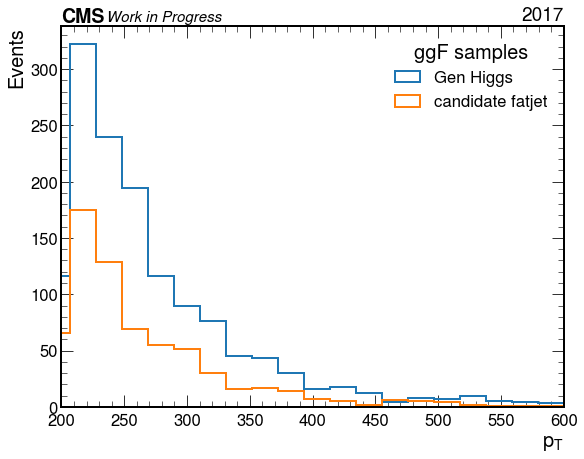

In [311]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(9, 7))

higgs_pt = ak.flatten(higgs).pt
higgs_pt = higgs_pt[higgs_pt>200]

fj_pt = ak.flatten(candidatefj, axis=0).pt
fj_pt = fj_pt[fj_pt>200]

ax.hist(higgs_pt, label=r"Gen Higgs", histtype="step", linewidth=2, bins=np.linspace(0,600,30))
ax.hist(fj_pt, label="candidate fatjet", histtype="step", linewidth=2, bins=np.linspace(0,600,30))

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.set_xlim(200, 600)
ax.legend(title=f"ggF samples")
ax.set_ylabel(r"Events"); 
ax.set_xlabel(r"$p_T$");
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# ax.set_yscale("log")

# plt.savefig(f"/Users/fmokhtar/Desktop/hww/gen_higgs_pt.pdf", bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


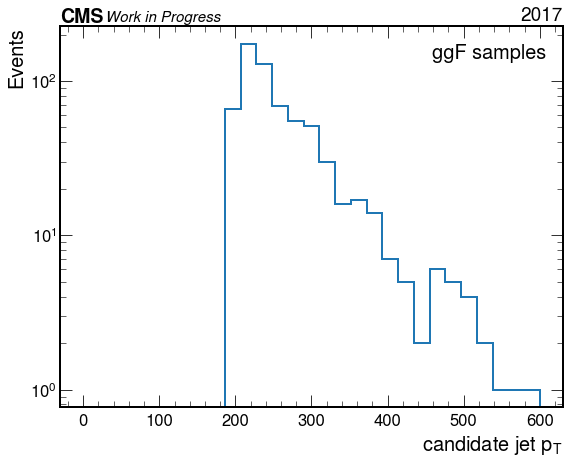

In [296]:

plt.rcParams.update({"font.size": 20})
### save plot
fig, ax = plt.subplots(figsize=(9, 7))
ax.hist(ak.flatten(candidatefj, axis=0).pt, histtype="step", linewidth=2, bins=np.linspace(0,600,30))

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.legend(title=f"ggF samples")
ax.set_ylabel(r"Events"); 
ax.set_xlabel(r"candidate jet $p_T$");
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
ax.set_yscale("log")

# plt.savefig(f"/Users/fmokhtar/Desktop/hww/gen_higgs_pt.pdf", bbox_inches='tight')

In [254]:
print(f"Number of events with a candidatelep: {len(ak.flatten(candidatelep, axis=0))}")
print(f"Number of events with a candidatelep of pt>200: {ak.sum(candidatelep.pt>200)}")
print("-----------------------")
print(f"Number of events with a jet: {len(ak.flatten(events.Jet, axis=1))}")
print(f"Number of events with a good jet: {len(ak.flatten(goodjets, axis=1))}")
print("-----------------------")
print(f"Number of events with a fatjet: {len(ak.flatten(fatjets, axis=1))}")
print(f"Number of events with a good fatjet: {len(ak.flatten(good_fatjets, axis=1))}")
print(f"Number of events with a candidatefj: {len(ak.flatten(candidatefj, axis=0))}")
print(f"Number of events with a candidatefj of pt>200: {ak.sum(candidatefj.pt>200)}")

Number of events with a candidatelep: 16981
Number of events with a candidatelep of pt>200: 51
-----------------------
Number of events with a jet: 526289
Number of events with a good jet: 134498
-----------------------
Number of events with a fatjet: 3497
Number of events with a good fatjet: 2130
Number of events with a candidatefj: 660
Number of events with a candidatefj of pt>200: 660


In [257]:
ak.flatten(candidatefj, axis=0).pt

<Array [210, 234, 203, 350, ... 309, 220, 354] type='660 * float32[parameters={"...'>

In [258]:
ak.flatten(candidatelep, axis=0).pt

<Array [31.9, 37.5, 43.3, ... 44.8, 53.8, 34.3] type='16981 * float32'>

In [261]:
candidatelep

<Array [None, None, Muon, ... None, None, None] type='98400 * ?union[muon, elect...'>

In [267]:
np.where(candidatefj.pt)

(<Array [0, 1, 2, 3, ... 98397, 98398, 98399] type='98074 * int64'>,)

In [269]:
candidatefj.pt

<Array [None, None, None, ... None, None, None] type='98400 * ?float32[parameter...'>

In [10]:
candidatelep

<FatJetArray [None, None, None, ... None, None, None] type='98400 * ?fatJet'>

In [93]:
# events with a candidate jet
np.where(~ak.is_none(candidatefj))

(<Array [53, 99, 308, ... 98169, 98199, 98354] type='660 * int64'>,)

In [312]:
# check the candidate lepton in one of those events
candidatelep[53].genPartIdxG

1893

In [329]:
events.FatJet[53]

<FatJetArray [FatJet, FatJet] type='2 * fatJet'>

In [328]:
1893 in events.FatJet[53][0]["pFCandsIdxG"]

False

In [330]:
1893 in events.FatJet[53][1]["pFCandsIdxG"]

False

In [338]:
events.FatJet[53].electronIdx3SJ

<Array [-1, 0] type='2 * int32[parameters={"__doc__": "index of electron matched...'>

In [107]:
candidatelep.jetIdx[53]

3

In [113]:
events.Jet[53]

<JetArray [Jet, Jet, Jet, Jet, ... Jet, Jet, Jet] type='8 * jet'>

In [ ]:
candidatelep.jetIdx[53]

In [115]:
events.Jet[53].delta_r(candidatelep[53])

<Array [3.2, 0.657, 1.38, ... 2.64, 2.89, 1.94] type='8 * float32'>

In [103]:
candidatefj.tightleptonJetID

AttributeError: no field named 'tightleptonJetID'

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.2/src/awkward/highlevel.py#L1124)

In [151]:
events.FatJet.fields

['area',
 'btagCSVV2',
 'btagDDBvLV2',
 'btagDDCvBV2',
 'btagDDCvLV2',
 'btagDeepB',
 'btagHbb',
 'deepTagMD_H4qvsQCD',
 'deepTagMD_HbbvsQCD',
 'deepTagMD_TvsQCD',
 'deepTagMD_WvsQCD',
 'deepTagMD_ZHbbvsQCD',
 'deepTagMD_ZHccvsQCD',
 'deepTagMD_ZbbvsQCD',
 'deepTagMD_ZvsQCD',
 'deepTagMD_bbvsLight',
 'deepTagMD_ccvsLight',
 'deepTag_H',
 'deepTag_QCD',
 'deepTag_QCDothers',
 'deepTag_TvsQCD',
 'deepTag_WvsQCD',
 'deepTag_ZvsQCD',
 'eta',
 'mass',
 'msoftdrop',
 'n2b1',
 'n3b1',
 'particleNetMD_QCD',
 'particleNetMD_Xbb',
 'particleNetMD_Xcc',
 'particleNetMD_Xqq',
 'particleNet_H4qvsQCD',
 'particleNet_HbbvsQCD',
 'particleNet_HccvsQCD',
 'particleNet_QCD',
 'particleNet_TvsQCD',
 'particleNet_WvsQCD',
 'particleNet_ZvsQCD',
 'particleNet_mass',
 'phi',
 'pt',
 'rawFactor',
 'tau1',
 'tau2',
 'tau3',
 'tau4',
 'lsf3',
 'jetId',
 'subJetIdx1',
 'subJetIdx2',
 'electronIdx3SJ',
 'muonIdx3SJ',
 'nConstituents',
 'DDX_tau1_flightDistance2dSig',
 'DDX_tau1_trackEtaRel_0',
 'DDX_tau1_trackEt

In [152]:
events.FatJet.subJetIdxG.__doc__

'index of first subjet'

In [127]:
candidatelep.fields

['dxy',
 'dxyErr',
 'dz',
 'dzErr',
 'eta',
 'ip3d',
 'jetPtRelv2',
 'jetRelIso',
 'mass',
 'miniPFRelIso_all',
 'miniPFRelIso_chg',
 'pfRelIso03_all',
 'pfRelIso03_chg',
 'phi',
 'pt',
 'sip3d',
 'mvaTTH',
 'charge',
 'jetIdx',
 'pdgId',
 'tightCharge',
 'isPFcand',
 'jetNDauCharged',
 'genPartIdx',
 'genPartFlav',
 'cleanmask',
 'genPartIdxG',
 'jetIdxG']

In [37]:
fatjets.particleNetMD_Xbb

<Array [[], [], [], [], ... [], [], [], []] type='98400 * var * float32[paramete...'>

In [26]:
candidatefj[~ak.is_none(candidatefj)].pt

<Array [210, 234, 203, 350, ... 309, 220, 354] type='660 * ?float32[parameters={...'>

In [147]:
events.Muon.dz

<Array [[], [], [0.00812, ... [0.00706], []] type='98400 * var * float32[paramet...'>

In [12]:
dr_jet_lepfj = goodjets.delta_r(candidatefj)

In [13]:
btagWPs = {
    "deepJet": {
        "2016APV": {
            "L": 0.0508,
            "M": 0.2598,
            "T": 0.6502,
        },
        "2016": {
            "L": 0.0480,
            "M": 0.2489,
            "T": 0.6377,
        },
        "2017": {
            "L": 0.0532,
            "M": 0.3040,
            "T": 0.7476,
        },
        "2018": {
            "L": 0.0490,
            "M": 0.2783,
            "T": 0.7100,
        },
    }
}

In [31]:
a = pd.read_parquet("../outfiles/0-1_ele.parquet")

In [34]:
a["n_bjets_ophem_M"]

0      0
1      0
2      0
3      0
4      0
      ..
658    1
659    0
660    0
661    0
662    0
Name: n_bjets_ophem_M, Length: 663, dtype: int64

In [ ]:
n_bjets = ak.sum(goodjets[dr_jet_lepfj > 0.8].btagDeepFlavB>0.3, axis=1)

In [320]:
candidatefj.pt

<Array [None, None, None, ... None, None, None] type='98400 * ?float32[parameter...'>

In [260]:
good_fatjets.delta_phi(met)

<Array [None, None, [], ... None, None, None] type='98400 * option[var * float32]'>

In [374]:
x = candidatefj.mass[~ak.is_none(candidatefj.mass)]
y = (candidatefj-candidatelep_p4).mass[~ak.is_none((candidatefj-candidatelep_p4).mass)]

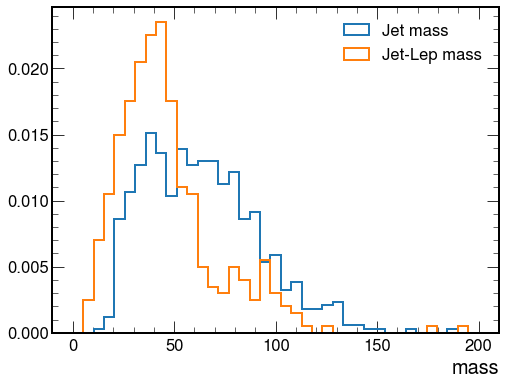

In [376]:
fig, ax = plt.subplots(figsize=(8,6))
bins = np.linspace(0, 200, 40)

for sample in ["HWW"]:
    ax.hist(x, bins, histtype="step", linewidth=2, label = f"Jet mass", density=True)
    ax.hist(y, bins, histtype="step", linewidth=2, label = f"Jet-Lep mass", density=True)
    ax.legend()
    # ax.set_ylim(0, 20000)
    ax.set_xlabel(r"mass")
#     ax.set_yscale("log")

In [433]:
"""
Using the reference https://cds.cern.ch/record/1630709/files/MSc_thesis_Stefan_Richter_with_info_pages.pdf.
Also using:
    px = pt cos(phi)
    py = pt sin(phi)
    pz = pt sinh(eta)
"""

Lep = candidatelep_p4
Jet = candidatefj - Lep

### definitions
m_H = 125

m_Jet = Jet.mass
E_Jet = Jet.energy

m_Lep = Lep.mass
E_Lep = Lep.energy

# momentum vectors for Jet and Lep
px_Jet = Jet.pt * np.cos(Jet.phi)
py_Jet = Jet.pt * np.sin(Jet.phi)
pz_Jet = Jet.pt * np.sinh(Jet.eta)

px_Lep = Lep.pt * np.cos(Lep.phi)
py_Lep = Lep.pt * np.sin(Lep.phi)
pz_Lep = Lep.pt * np.sinh(Lep.eta)

pJet_dot_pLep = px_Jet*px_Lep + py_Jet*py_Lep + pz_Jet*pz_Lep

# met
px_met = met.pt * np.cos(met.phi)
py_met = met.pt * np.sin(met.phi)

# computation:
Last_term = (px_met*(px_Jet+px_Lep) + py_met*(py_Jet+py_Lep))
A = (1/(E_Jet+E_Lep)) * ( 0.5*(m_H**2 - m_Jet**2 - m_Lep**2) - E_Jet*E_Lep + pJet_dot_pLep + Last_term )

B = (pz_Jet**2 + pz_Lep**2) / (E_Jet + E_Lep)

D = A**2 - (px_met**2 + py_met**2)*(1-B**2)

# reconstruct the met pz
pz_met_pos = ( (A*B) + np.sqrt(D) ) / (1-B**2)
pz_met_neg = ( (A*B) - np.sqrt(D) ) / (1-B**2)

In [421]:
pz_met_pos = pz_met_pos[~ak.is_none(pz_met_pos)]
pz_met_neg = pz_met_neg[~ak.is_none(pz_met_neg)]

Text(1, 0, 'MET $p_z$')

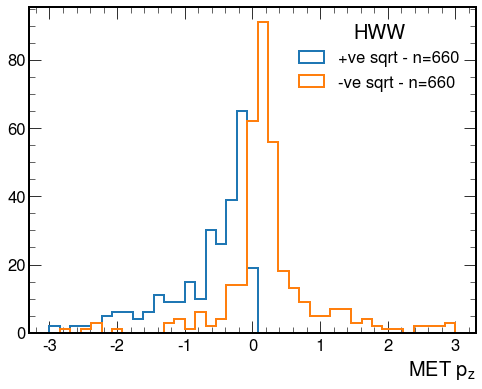

In [395]:
import math
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8,6))
bins = np.linspace(-3, 3, 40)
ax.hist(pz_met_pos, bins, histtype="step", linewidth=2, label = f"+ve sqrt - n={len(pz_met_pos)}")
ax.hist(pz_met_neg, bins, histtype="step", linewidth=2, label = f"-ve sqrt - n={len(pz_met_neg)}")
ax.legend(title="HWW")
# ax.set_ylim(0, 20000)
ax.set_xlabel(r"MET $p_z$")

# Reconstruct the higgs

In [443]:
### pick smallest pz because we expect heavy physics to result in central object which has hight pT (artifact of pdf proton) - more probable to have less pT in z axis

met1 = ak.zip(
        {
            "pt": met.pt,
            "eta": np.arcsinh(pz_met/met.pt),
#             "eta": candidatelep_p4.eta,
            "phi": met.phi,
            "mass": 0,
#             "charge": cand.charge,
        },
        with_name="PtEtaPhiMCandidate",
        behavior=candidate.behavior,
    )
# met2 = ak.zip(
#         {
#             "pt": met.pt,
# #             "eta": np.arcsinh(pz_met_neg/met.pt),
#             "eta": candidatelep_p4.eta,
#             "phi": met.phi,
#             "mass": 0,
# #             "charge": cand.charge,
#         },
#         with_name="PtEtaPhiMCandidate",
#         behavior=candidate.behavior,
#     )

ValueError: cannot broadcast records in this type of operation

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/awkward/_util.py#L1066)

In [444]:
rec_higgs1 = Jet+met1
rec_higgs1 = rec_higgs1[~ak.is_none(rec_higgs1)].mass

# rec_higgs2 = Jet+met2
# rec_higgs2 = rec_higgs2[~ak.is_none(rec_higgs2)].mass

Text(1, 0, 'rec Higgs mass')

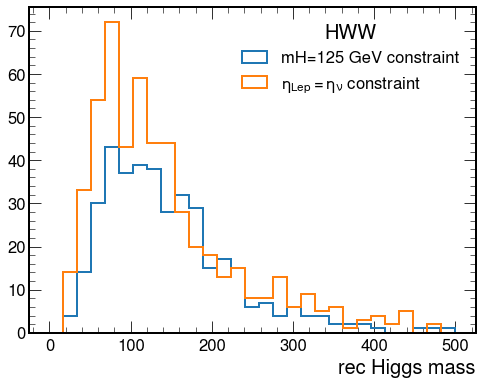

In [445]:
fig, ax = plt.subplots(figsize=(8,6))
bins = np.linspace(0, 500, 30)

ax.hist(rec_higgs1, bins, histtype="step", linewidth=2, label = f"mH=125 GeV constraint")
ax.hist(rec_higgs2, bins, histtype="step", linewidth=2, label = r"$\eta_{Lep}=\eta_{\nu}$ constraint")
ax.legend(title="HWW")
# ax.set_ylim(0, 20000)
ax.set_xlabel(r"rec Higgs mass")

In [280]:
rec_higgs[~ak.is_none(rec_higgs)].mass

<Array [305, 536, 281, ... 320, 837, 1.02e+03] type='547 * ?float64'>

In [ ]:
# ->goal is to see sharp peak near 125

### 1. share the mT histogram (<100 and >100)

### 2. why blue is not sharp peak
### 3. orange is reasonable
### 4. use eta_neut=eta_jet